# Integral Analysis of GRB 230307A: Double QPO

Twice the QPOs, twice the fun?

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io
import pickle

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2023-10-26 07:59:14,498]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1698299954.498388       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-10-26 07:59:14,499]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-26 07:59:14,505]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

In [2]:
def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points

def plot_posterior_predictive(lc, res, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    print("Resampling done, calculating maximum posterior model ...")
    # split into samples belonging to the kernel, and samples 
    # belonging to the mean function
    kernel_params = stingray.modeling.gpmodeling._get_kernel_params(kernel_type)
    mean_params = stingray.modeling.gpmodeling._get_mean_params(mean_type)

    mean_samples = dict((k, samples_resampled[k]) for k in mean_params)

    maxpost_log = get_max_posterior_parameters(res)

    sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
    sm_maxpost_log = dict((k, maxpost_log[k]) for k in mean_params)

    sk_maxpost, sm_maxpost = {}, {}
    for params in kernel_params:
        if params[0:4] == "log_":
            sk_maxpost[params[4:]] = jnp.exp(sk_maxpost_log[params])
        else:
            sk_maxpost[params] = sk_maxpost_log[params]

    for params in mean_params:
        if params[0:4] == "log_":
            sm_maxpost[params[4:]] = jnp.exp(sm_maxpost_log[params])
        else:
            sm_maxpost[params] = sm_maxpost_log[params]
            
    print(mean_type)
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=sk_maxpost)
    mean = get_mean(mean_type=mean_type, mean_params=sm_maxpost)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean(lc.time))
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)
    _, cond = gp.condition(lc.counts, tgrid)

    mu = cond.loc + mean(tgrid)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = dict((k, mean_samples[k][idx]) for k in mean_params)
        sm = {}
        for params in mean_params:
            if params[0:4] == "log_":
                sm[params[4:]] = jnp.exp(sm_log[params])
            else:
                sm[params] = sm_log[params]

        mean = get_mean(mean_type=mean_type, mean_params=sm)
        mean_vals = mean(times)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(times, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(times, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

In [3]:
datadir = "/Users/daniela/work/data/grb230307A/"
figdir = "/Users/daniela/work/repositories/GRB230307A_QPOSearch/figures/"

data = scipy.io.readsav(datadir+"acs_lc_bary.sav")

barytime = np.array(data["barytime"], dtype=float)
minind = barytime.searchsorted(0.0)
maxind = barytime.searchsorted(60.0)

counts = np.array(data["counts"], dtype=float)

barytime = barytime[minind:maxind]
counts = counts[minind:maxind]

In [4]:
mean_bkg = np.mean(counts[-100:])

In [5]:
lc = Lightcurve(barytime, counts-mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-26 07:59:19,022]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-26 07:59:19,111]: Checking if light curve is sorted.
INFO[2023-10-26 07:59:19,195]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


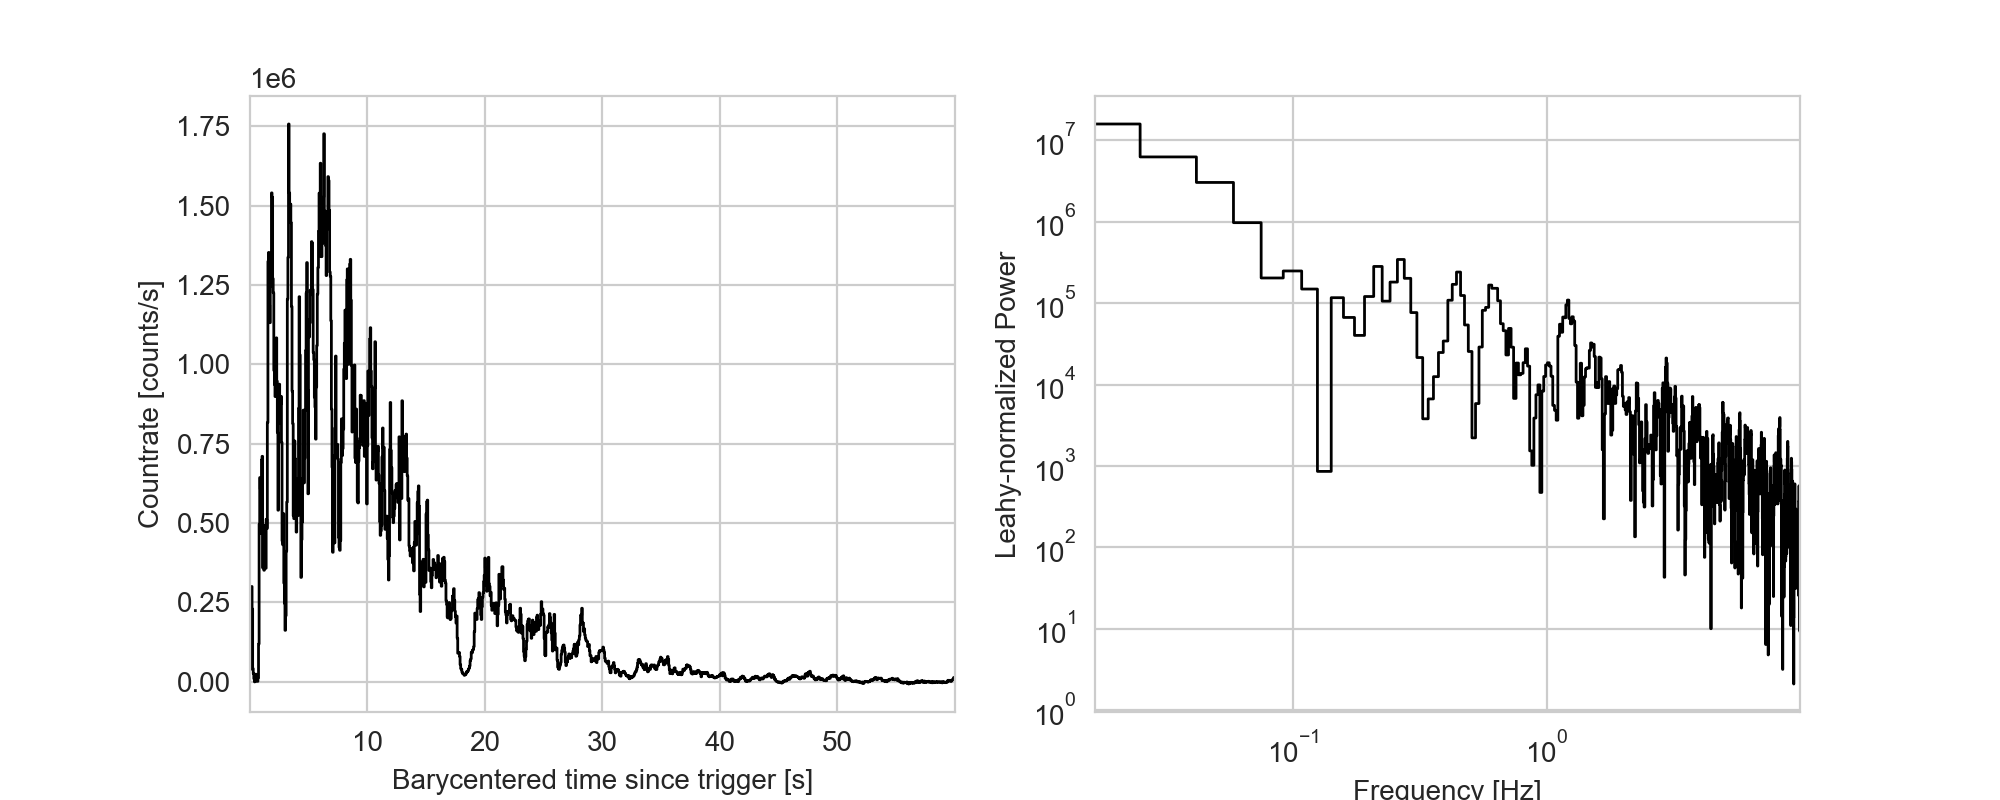

Text(0, 0.5, 'Leahy-normalized Power')

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

## A Model with two QPOs

Going to have to hack the GPModeling class to make this work:

In [7]:
def skewgaussian(t, params):
    """A skew gaussian flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.

    params: dict
        The dictionary contating parameter values of the skew gaussian flare.

        The parameters for the skew gaussian flare are:
        A:  jnp.float / jnp.ndarray
            Amplitude of the flare.
        t0: jnp.float / jnp.ndarray
            The location of the maximum.
        sig1: jnp.float / jnp.ndarray
            The width parameter for the rising edge.
        sig2: jnp.float / jnp.ndarray
            The width parameter for the falling edge.

    Returns
    -------
    The y values for skew gaussian flare.
    """
    A = jnp.atleast_1d(jnp.exp(params["logA"]))[:, jnp.newaxis]
    t0 = jnp.atleast_1d(params["t0"])[:, jnp.newaxis]
    sig1 = jnp.atleast_1d(jnp.exp(params["logsig1"]))[:, jnp.newaxis]
    sig2 = jnp.atleast_1d(jnp.exp(params["logsig2"]))[:, jnp.newaxis]

    y = jnp.sum(
        A
        * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (sig2**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (sig1**2))),
        ),
        axis=0,
    )
    return y

Let's set up a kernel with two QPOs and sample a GRB:

In [21]:
params = {"logA": 11.0,
          "t0": 5.0,
          "logsig1": np.log(0.5),
          "logsig2": np.log(20.0),
          "log_arn": 16.0,
          "log_crn": 1.0,
          "log_aqpo1": 15,
          "log_cqpo1": -2,
          "log_freq1": np.log(1./0.82),
          "log_aqpo2": 14.0, 
          "log_cqpo2": -2,
          "log_freq2": np.log(1./0.34)}

kernel = kernels.quasisep.Exp(
    scale=1 / jnp.exp(params["log_crn"]), sigma=(jnp.exp(params["log_arn"])) ** 0.5
) + kernels.quasisep.Celerite(
    a=jnp.exp(params["log_aqpo1"]),
    b=0.0,
    c=jnp.exp(params["log_cqpo1"]),
    d=2 * jnp.pi * jnp.exp(params["log_freq1"])
) + kernels.quasisep.Celerite(
    a=jnp.exp(params["log_aqpo2"]),
    b=0.0,
    c=jnp.exp(params["log_cqpo2"]),
    d=2 * jnp.pi * jnp.exp(params["log_freq2"])
)

mean_vals = skewgaussian(lc.time, params)

gp = GaussianProcess(kernel, lc.time, mean_value=mean_vals, diag=lc.counts)

In [25]:
sample = gp.sample(random.PRNGKey(132))

lcsample = Lightcurve(lc.time, sample)
pssample = Powerspectrum(lcsample, norm="leahy")

INFO[2023-10-26 08:18:45,894]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-26 08:18:45,980]: Checking if light curve is sorted.
INFO[2023-10-26 08:18:45,981]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


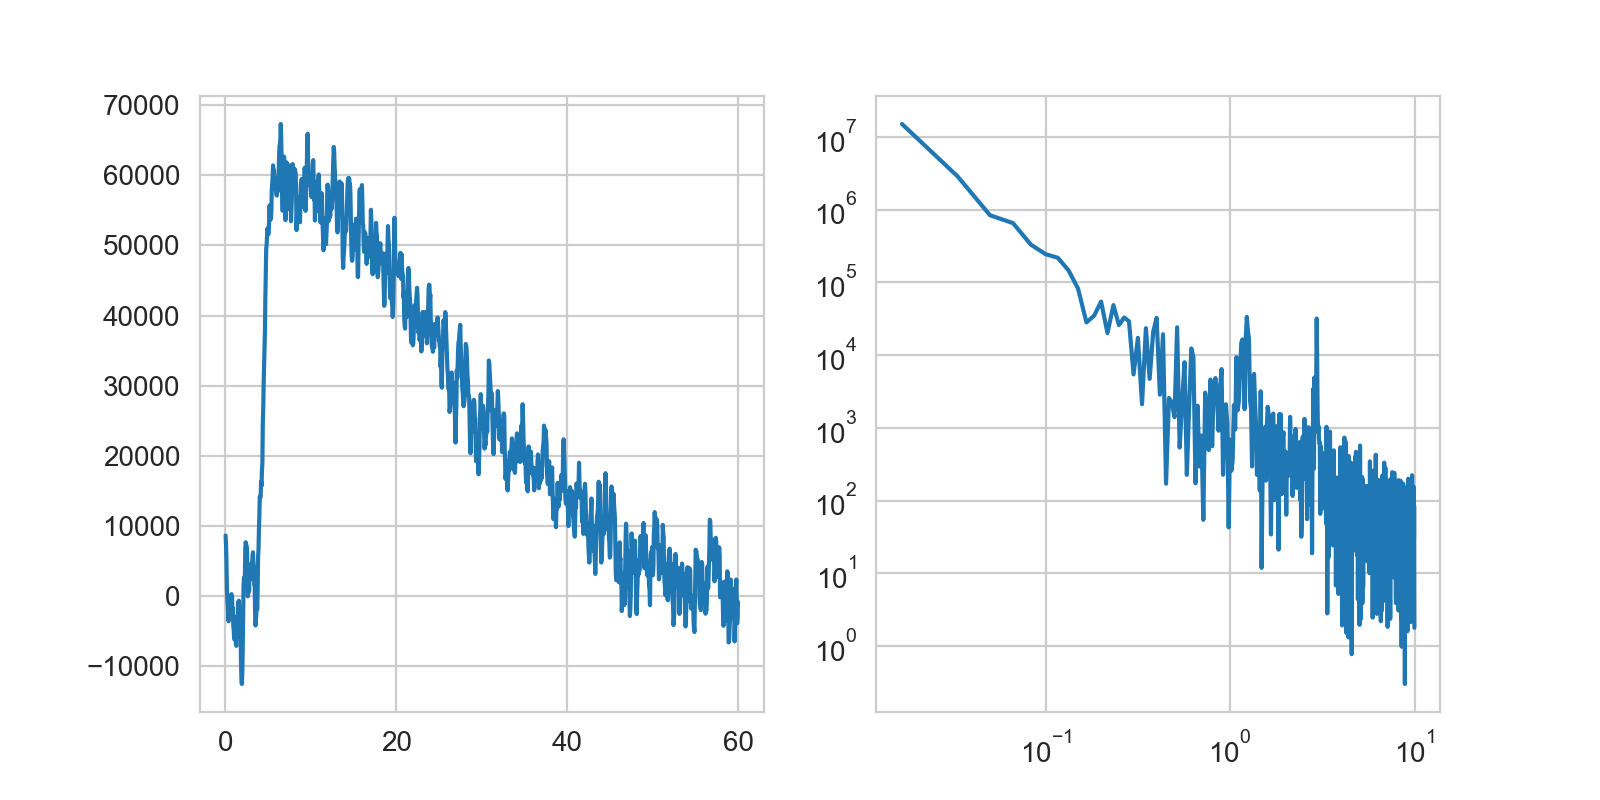

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(lc.time, sample)

ax2.loglog(pssample.freq, pssample.power)

Okay, so in principle, this seems to work

In [89]:
def loglike(*args):

    params_list = ["logA", "t0", "logsig1", "logsig2",
                  "log_crn", "log_arn",
                  "log_aqpo1", "log_omega1", "log_quality1",
                  "log_aqpo2", "log_omega2", "log_quality2"]
    
    params = {}
    for i,p in enumerate(params_list):
        params[p] = args[i]
        
    #kernel = kernels.quasisep.Exp(
    #    scale=1 / jnp.exp(params["log_crn"]), sigma=(jnp.exp(params["log_arn"])) ** 0.5
    #) + kernels.quasisep.Celerite(
    #    a=jnp.exp(params["log_aqpo1"]),
    #    b=0.0,
    #    c=jnp.exp(params["log_cqpo1"]),
    #    d=2 * jnp.pi * jnp.exp(params["log_freq1"])
    #) + kernels.quasisep.Celerite(
    #    a=jnp.exp(params["log_aqpo2"]),
    #    b=0.0,
    #    c=jnp.exp(params["log_cqpo2"]),
    #    d=2 * jnp.pi * jnp.exp(params["log_freq2"])
    #)
    
    kernel = kernels.quasisep.Exp(
        scale=1 / jnp.exp(params["log_crn"]), sigma=(jnp.exp(params["log_arn"])) ** 0.5
    ) + kernels.quasisep.SHO(
        omega = jnp.exp(params["log_omega1"]),
        quality = jnp.exp(params["log_quality1"]),
        sigma = jnp.exp(params["log_aqpo1"])
    ) + kernels.quasisep.SHO(
        omega = jnp.exp(params["log_omega2"]),
        quality = jnp.exp(params["log_quality2"]),
        sigma = jnp.exp(params["log_aqpo2"])
    )  
        
    mean_vals = skewgaussian(lc.time, params)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean_vals, diag=lc.counts)
    log_like = jnp.nan_to_num(gp.log_probability(lc.counts), nan=-1e20, posinf=-1e20, neginf=-1e20)

    return log_like

In [108]:
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "logA": tfpd.Uniform(5, 15),
    "logsig1": tfpd.Uniform(-1, 3.5),
    "logsig2": tfpd.Uniform(1, 4.0),
    "log_aqpo1": tfpd.Uniform(2, 20),
    "log_omega1": tfpd.Uniform(jnp.log(2.*np.pi*1.0), jnp.log(2.*np.pi*5.0)),
    "log_quality1": tfpd.Uniform(jnp.log(2.0), jnp.log(100.0)),
    "log_aqpo2": tfpd.Uniform(2, 20),
    "log_omega2": tfpd.Uniform(jnp.log(2.*np.pi*1.0), jnp.log(2.*np.pi*5.0)),
    "log_quality2": tfpd.Uniform(jnp.log(2.0), jnp.log(100.0)),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}
    
params_list = ["logA", "t0", "logsig1", "logsig2",
              "log_crn", "log_arn",
              "log_aqpo1", "log_omega1", "log_quality1",
              "log_aqpo2", "log_omega2", "log_quality2"]


prior_model = get_prior(params_list, prior_dict)


In [109]:
from jaxns import ExactNestedSampler, TerminationCondition, Prior, Model
from jaxns.utils import resample

In [121]:
nsmodel = Model(prior_model=prior_model, log_likelihood=loglike)
nsmodel.sanity_check(random.PRNGKey(10), S=100)

num_live_points = 4000
max_samples = 1e5

exact_ns = ExactNestedSampler(nsmodel, num_live_points=num_live_points, max_samples=max_samples)

INFO[2023-10-27 12:01:20,237]: Sanity check...
INFO[2023-10-27 12:01:20,265]: Sanity check passed


In [123]:
termination_reason, state = exact_ns(
    random.PRNGKey(43), term_cond=TerminationCondition(live_evidence_frac=0.001)
)

In [124]:
results = exact_ns.to_results(state, termination_reason)

In [125]:
import pickle
with open(datadir + "integral_drw_doubleqpo.pkl", "wb") as f:
    pickle.dump(results, f)

In [126]:
def resample_posterior(res, rkey):
    """
    Resample Nested Sampling posterior sample 
    based on the weights to provide unbiased
    posterior samples.

    Parameters
    ----------
    res : jaxns.Results object
        The object with the posterior results of 
        the Nested Sampling run

    rkey : jax.RandomState key
        A random key for reproducibility

    Returns
    -------
    samples_resampled : dict
        A dictionary with the resampled samples
    """
    log_p = res.log_dp_mean #log-prob

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    return samples_resampled

In [127]:
import pandas as pd

In [132]:
samples_doubleqpo

{'logA': Array([10.89966516, 10.80056408, 10.80056408, 10.8231594 , 10.86843924,
        10.80056408, 10.85412663, 10.80766212, 10.94418531, 10.79981017],      dtype=float64),
 'log_aqpo1': Array([8.00544572, 8.11476069, 8.11476069, 8.2214594 , 7.92300635,
        8.11476069, 7.85571413, 8.07281468, 8.06832275, 7.7645474 ],      dtype=float64),
 'log_aqpo2': Array([6.33091608, 7.55255779, 7.55255779, 7.17407869, 7.08437935,
        7.55255779, 7.09214836, 7.14636006, 6.68228682, 7.08750382],      dtype=float64),
 'log_arn': Array([17.81359773, 17.71105173, 17.71105173, 18.16021057, 17.81236765,
        17.71105173, 17.61519343, 18.18598972, 18.07491847, 17.53971233],      dtype=float64),
 'log_crn': Array([1.03102325, 0.95532547, 0.95532547, 0.61331213, 0.86439282,
        0.95532547, 1.16603301, 0.42986711, 0.83488868, 1.09270893],      dtype=float64),
 'log_omega1': Array([2.04564934, 2.02896957, 2.02896957, 2.04921719, 2.00355435,
        2.02896957, 2.03099775, 2.02150296, 2.036380

In [128]:
samples_doubleqpo = resample_posterior(results, rkey=random.PRNGKey(13553))

df_doubleqpo = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_doubleqpo["logA"],
                      r"$t_0$": samples_doubleqpo["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_doubleqpo["logsig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_doubleqpo["logsig2"],
                      r"$\log(A_{\mathrm{rn}})$": samples_doubleqpo["log_arn"],
                      r"$\log(c_\mathrm{rn})$": samples_doubleqpo["log_crn"],
                      r"$\log(\omega_{c,1})$":samples_doubleqpo["log_omega1"],
                      r"$\log(A_{\mathrm{QPO},1})$":samples_doubleqpo["log_aqpo1"],
                      r"$\log(q_{\mathrm{QPO},1})$": samples_doubleqpo["log_quality1"],
                      r"$\log(\omega_{c,2})$":samples_doubleqpo["log_omega2"],
                      r"$\log(A_{\mathrm{QPO},2})$":samples_doubleqpo["log_aqpo2"],
                      r"$\log(q_{\mathrm{QPO},2})$": samples_doubleqpo["log_quality2"]
                               }
)

<IPython.core.display.Javascript object>


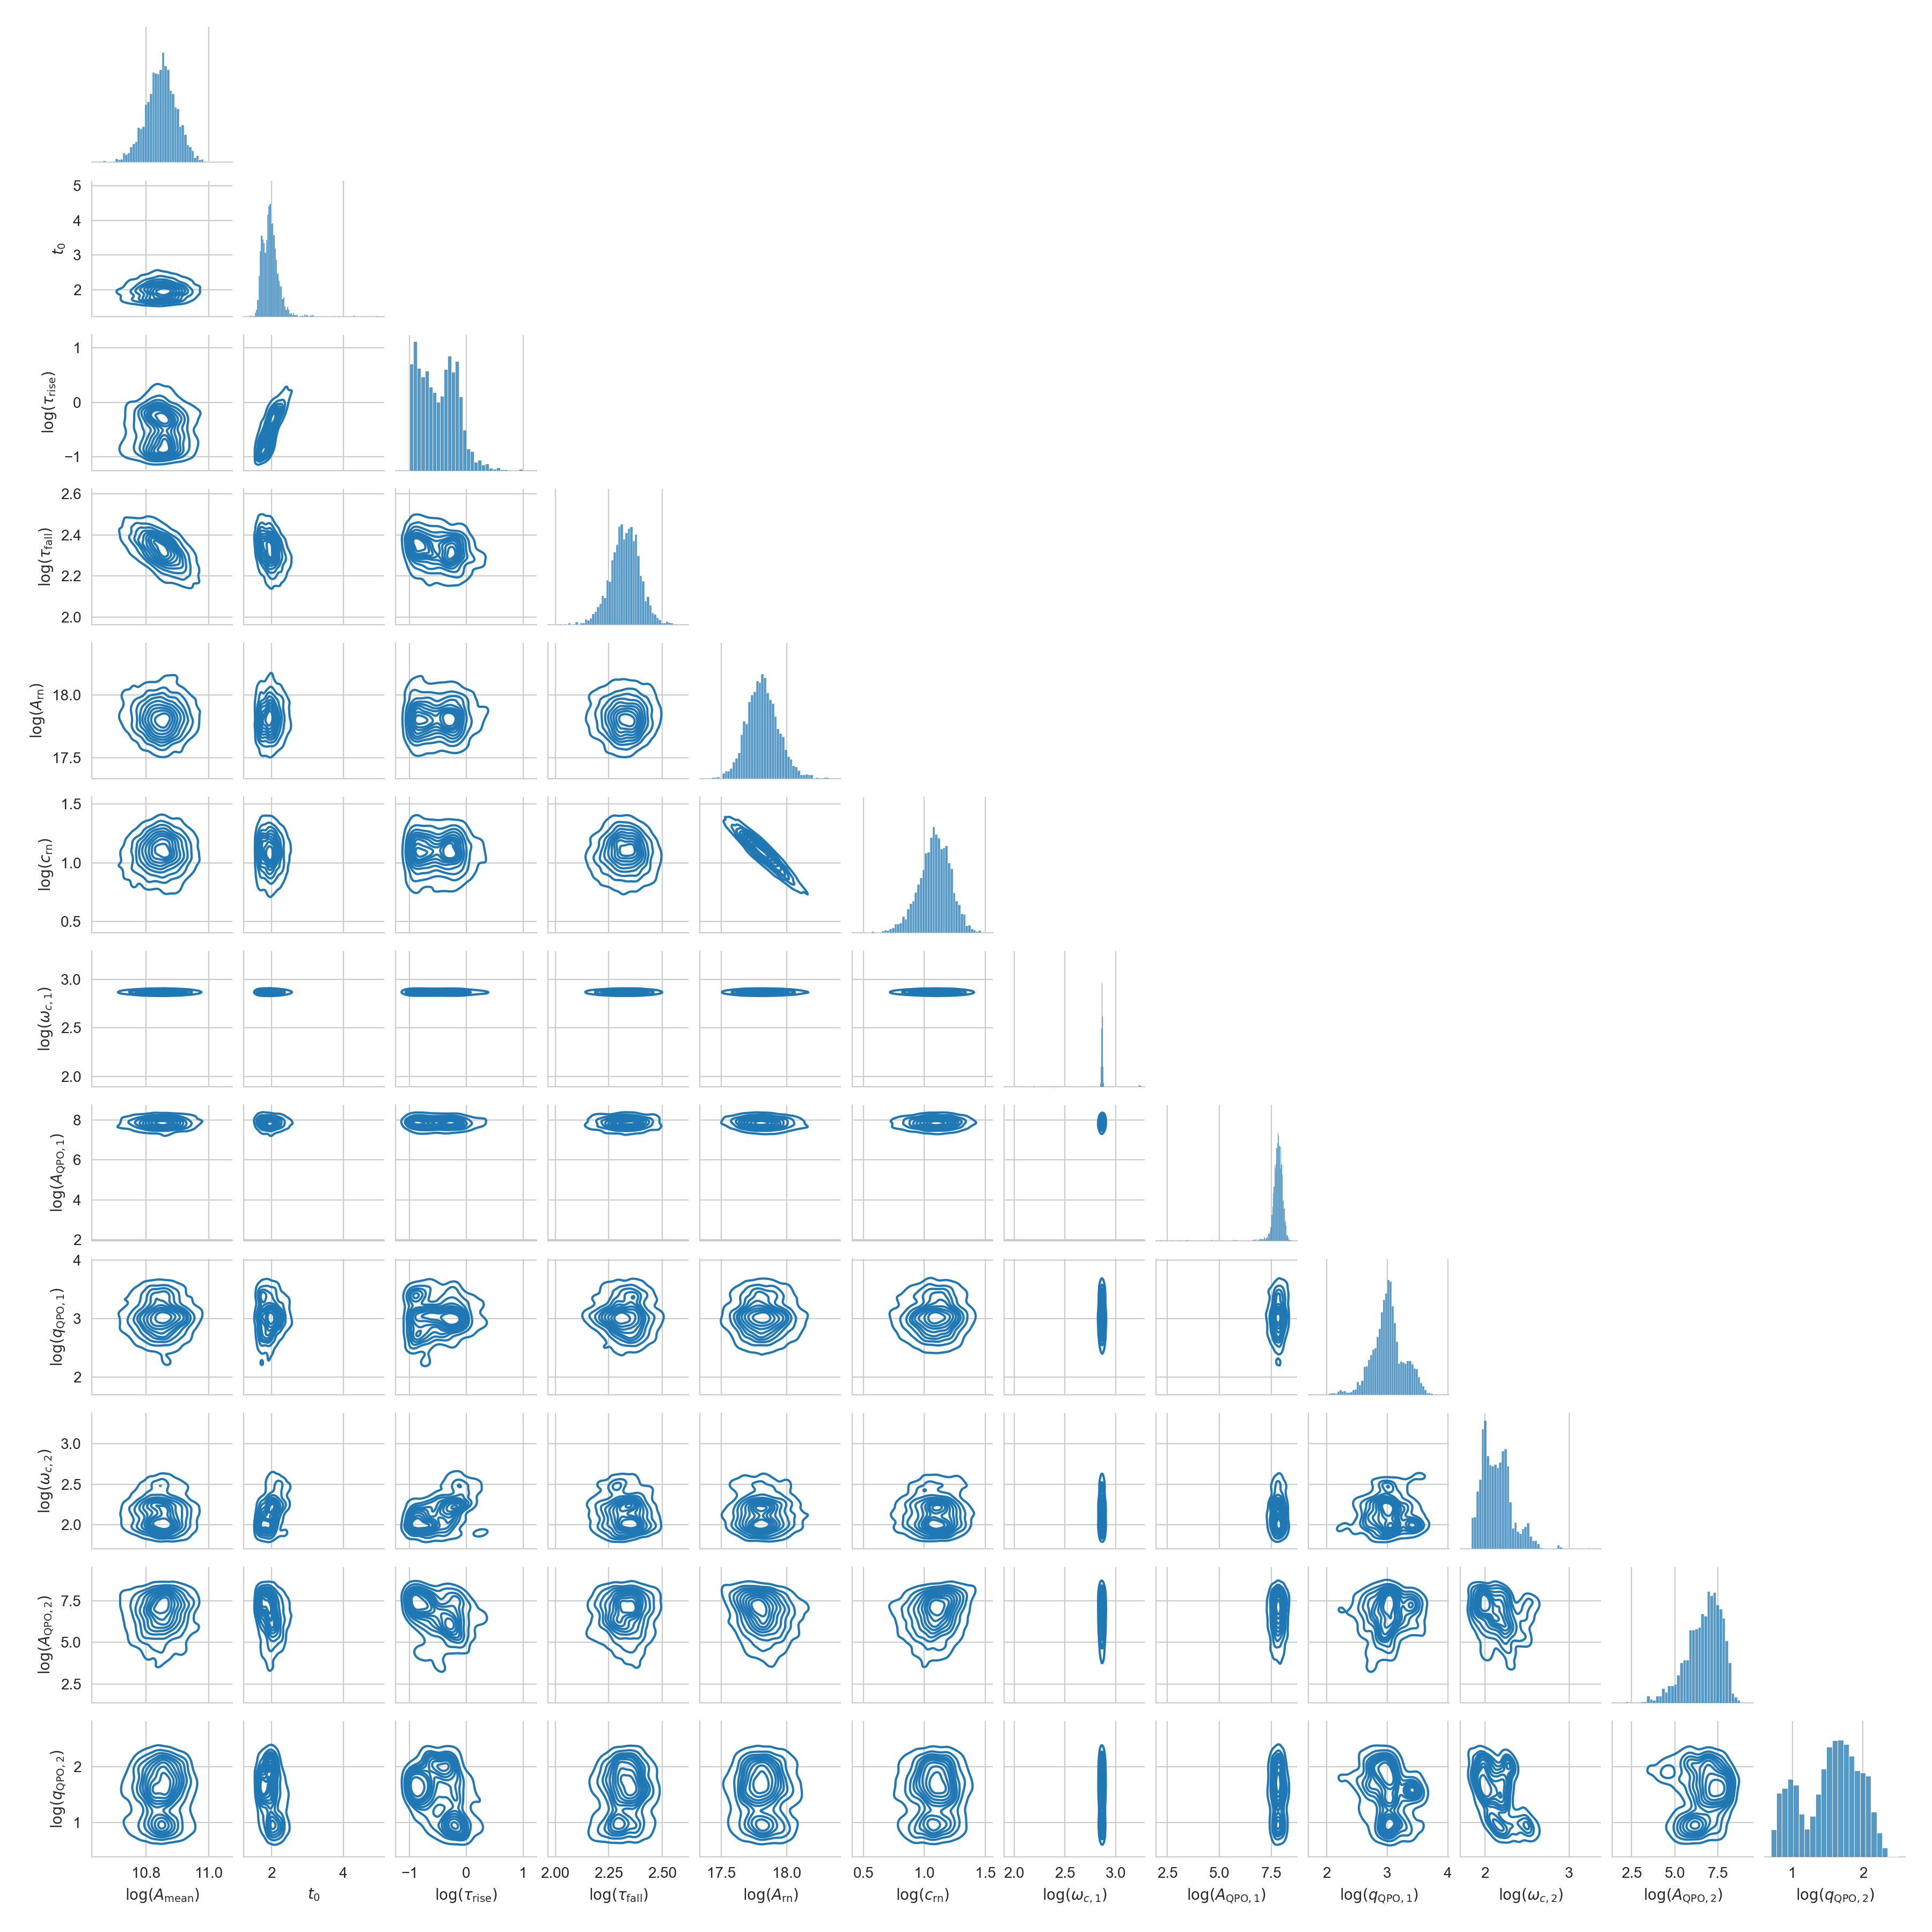

In [117]:
sns.pairplot(df_doubleqpo, corner=True, height=1.5, kind="kde", diag_kind="hist")
#plt.savefig(f"{figdir}integral_cutout_qpo_rn_corner.pdf", format="pdf")

In [129]:
freq1_resampled = samples_doubleqpo["log_omega1"]/(2.*np.pi)
freq2_resampled = samples_doubleqpo["log_omega2"]/(2.*np.pi)

<IPython.core.display.Javascript object>


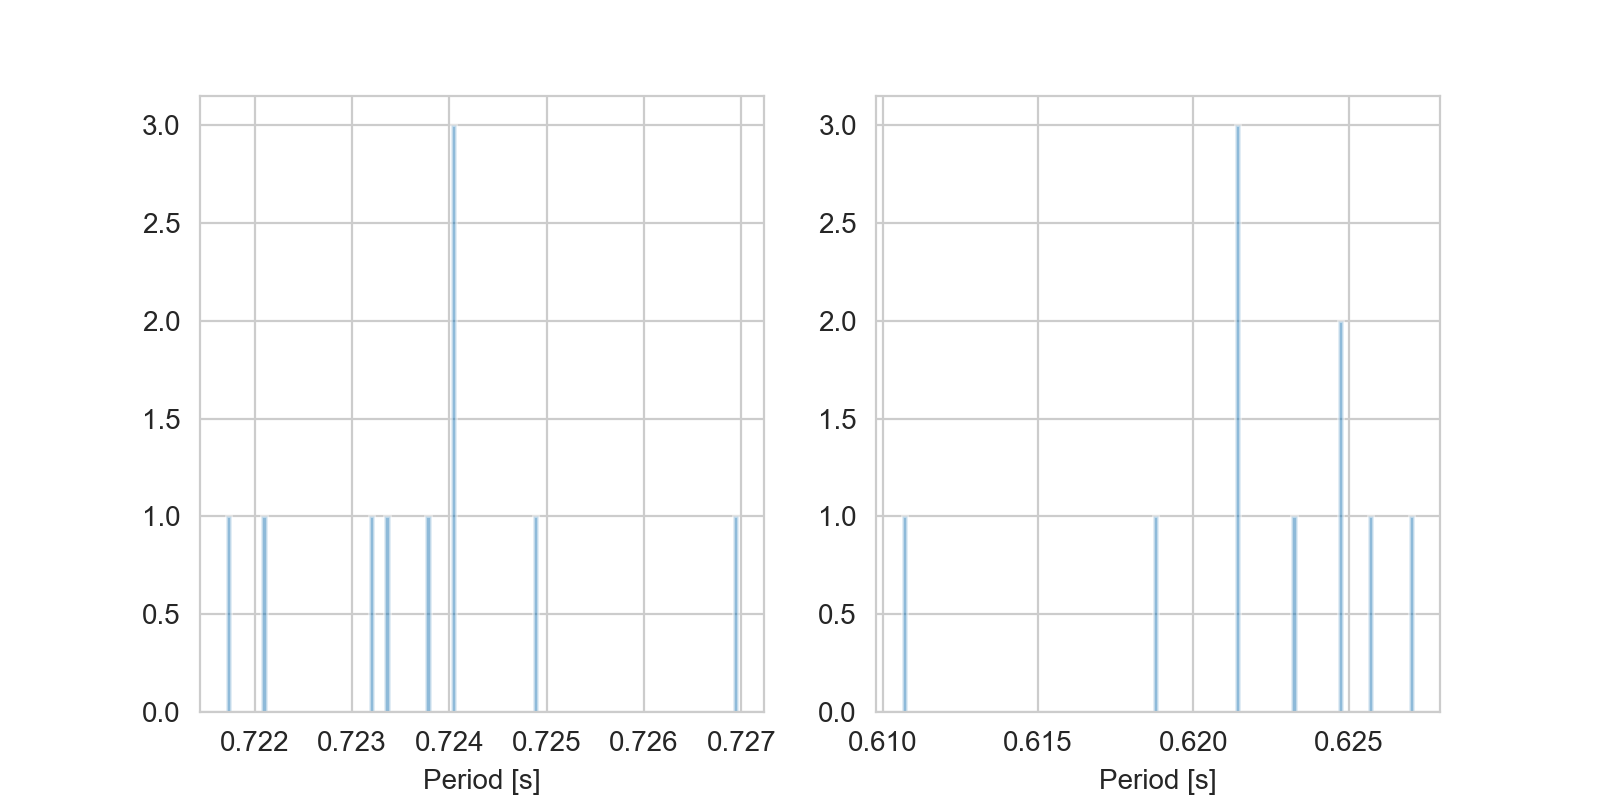

Text(0.5, 0, 'Period [s]')

In [130]:
freq1 = np.exp(freq1_resampled)
period1 = 1.0/freq1

freq2 = np.exp(freq2_resampled)
period2 = 1.0/freq2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(period1, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Period [s]")

ax2.hist(period2, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [131]:
results.log_Z_mean

Array(-11625.78570666, dtype=float64)

In [84]:
rn_evidence = -11639.800048880545
qporn_evidence = -11631.279312772167

In [7]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [8]:
times = lc.time
counts = lc.counts

In [10]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [12]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

INFO[2023-10-25 08:01:24,576]: Sanity check...
INFO[2023-10-25 08:01:24,581]: Sanity check passed


Simulation Complete


In [14]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -11639.800048880545


In [16]:
with open(datadir+"intregal_drw_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)

In [17]:
gpresult_rn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 4244716
# samples: 40500
# slices: 621000.0
# slices / acceptance: 18.0
# likelihood evals / sample: 104.8
# likelihood evals / slice: 6.8
--------
logZ=-11639.8 +- 0.12
H=12000.0
ESS=4546
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 10.847 +- 0.053 | 10.781 / 10.849 / 10.914 | 10.865 | 10.865
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 17.96 +- 0.12 | 17.82 / 17.95 / 18.11 | 17.9 | 17.9
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 1.0 +- 0.12 | 0.84 / 1.01 / 1.15 | 1.07 | 1.07
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: -0.67 +- 0.24 | -0.94 / -0.7 / -0.36 | -0.54 | -0.54
--------
log_sig2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig2: 2.333 +- 0.067 | 2.248 / 2.334 

<IPython.core.display.Javascript object>


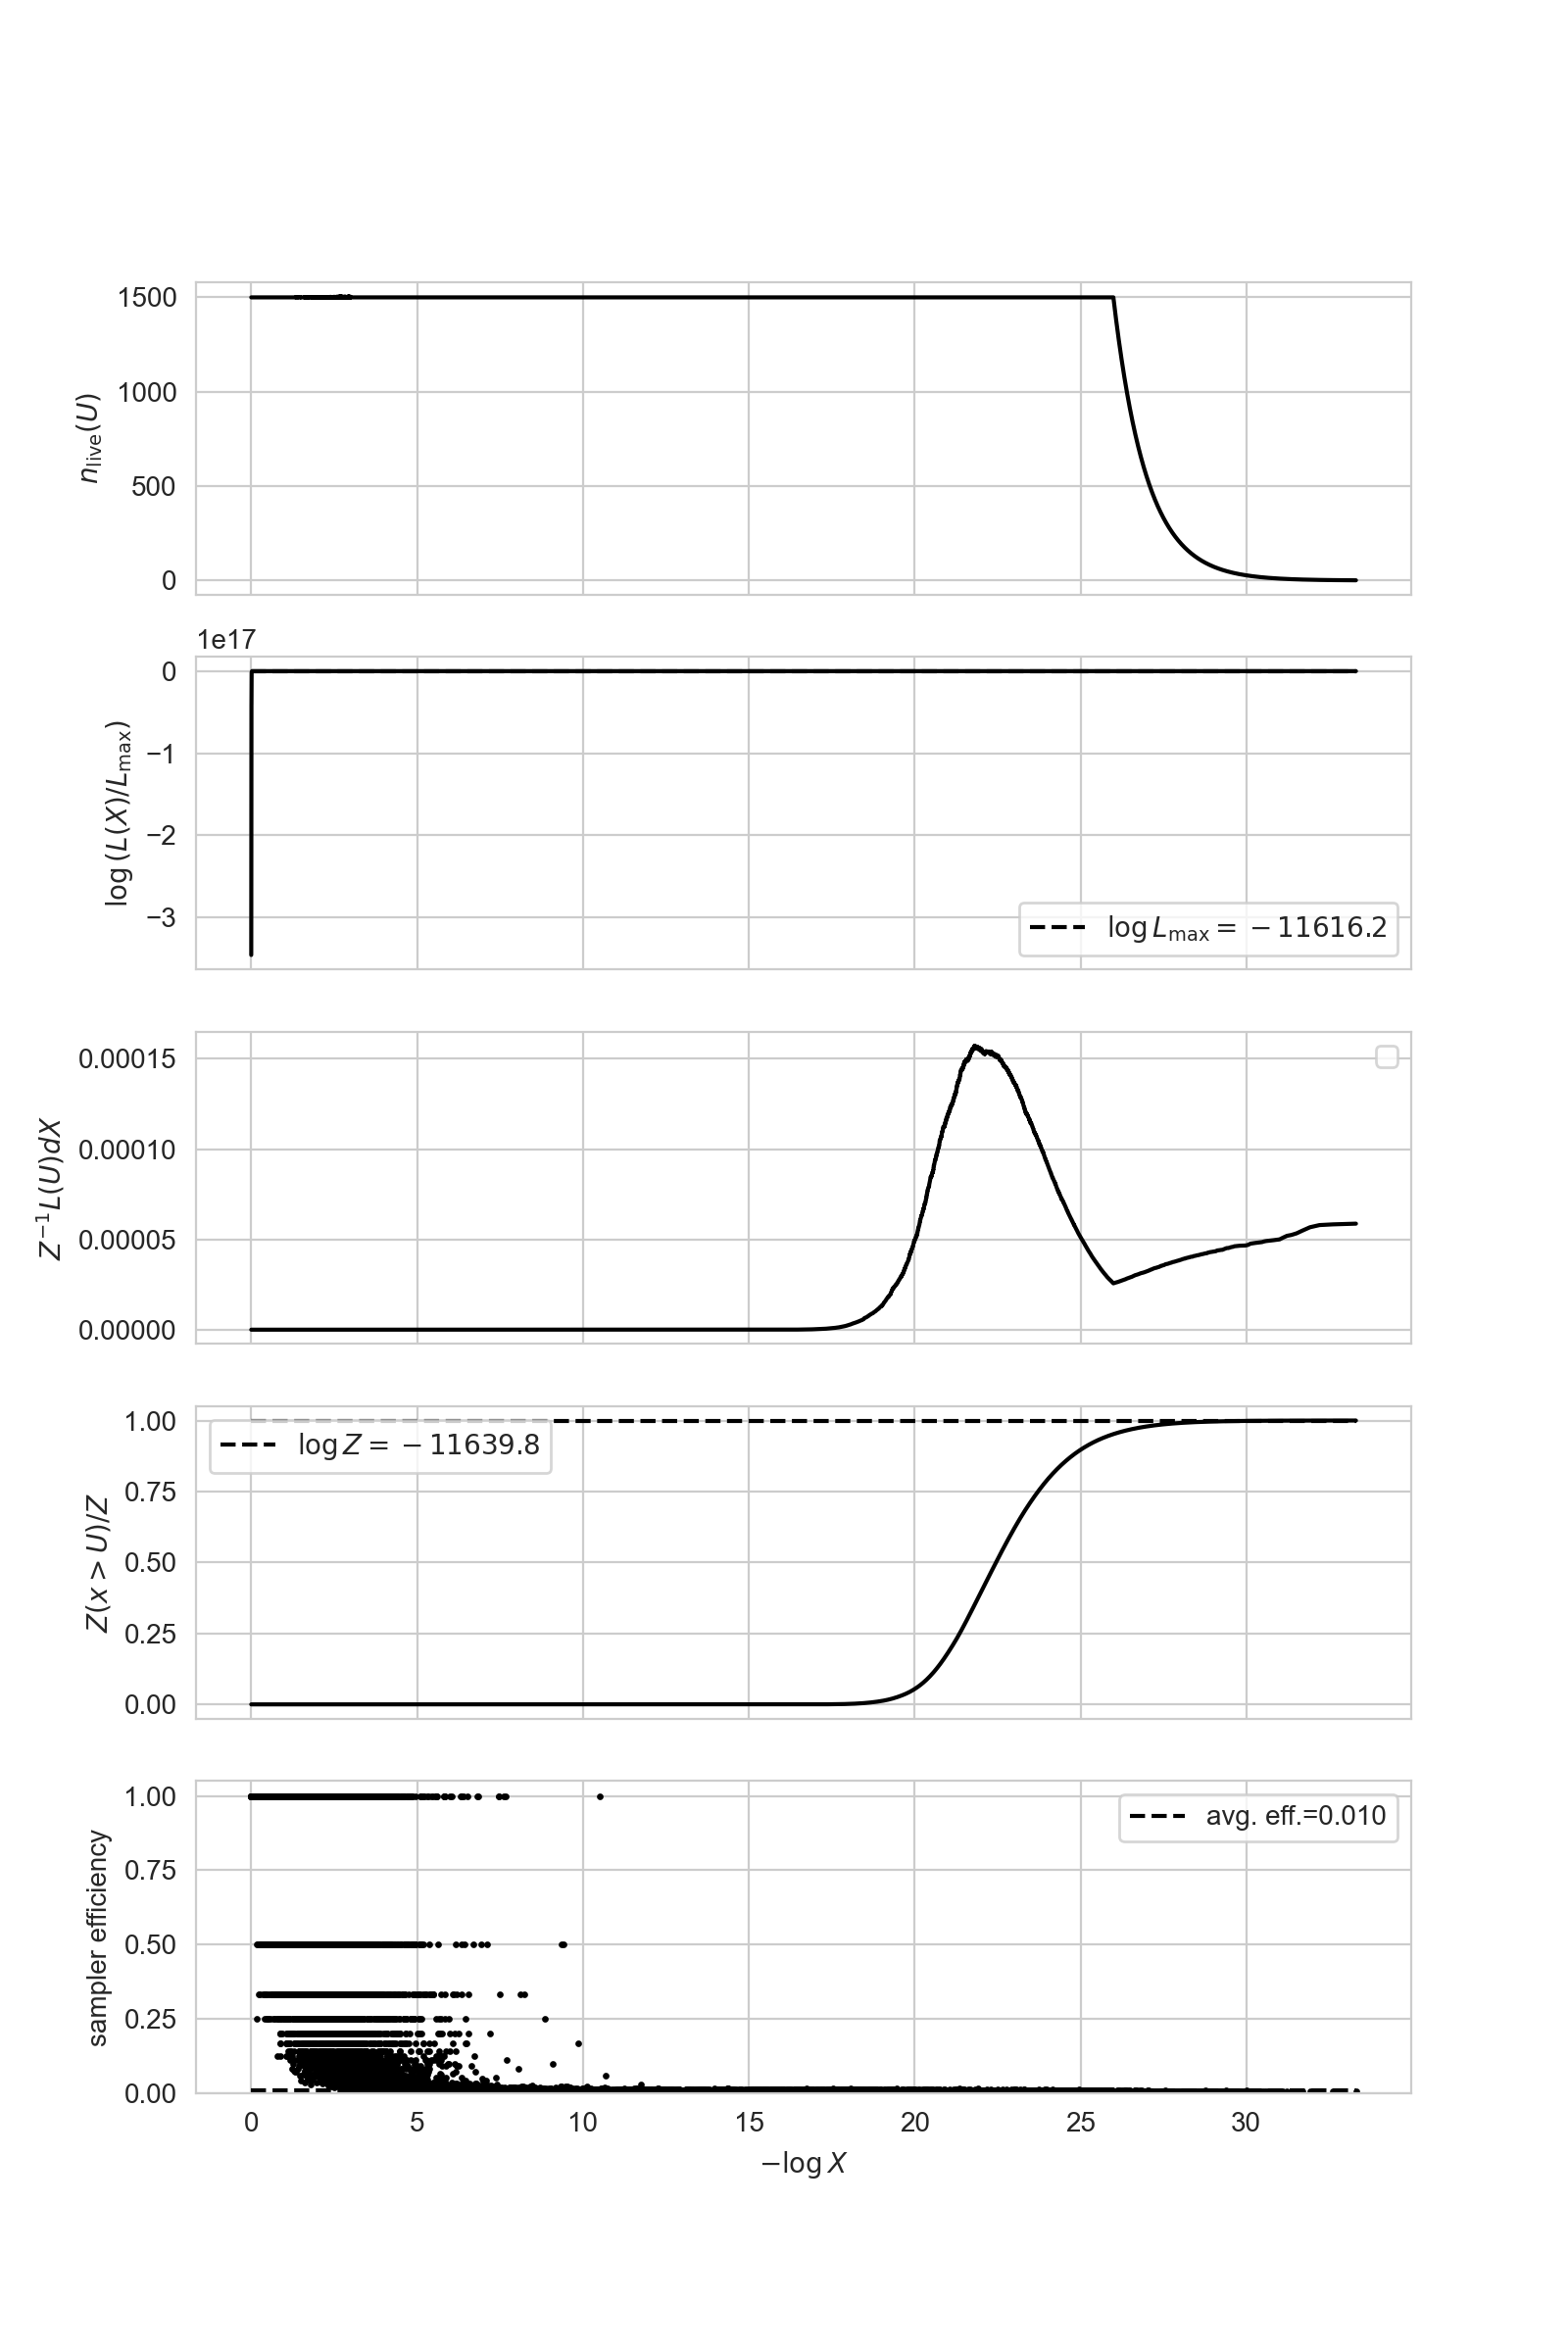

WARNING[2023-10-25 08:08:56,201]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [18]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

<IPython.core.display.Javascript object>


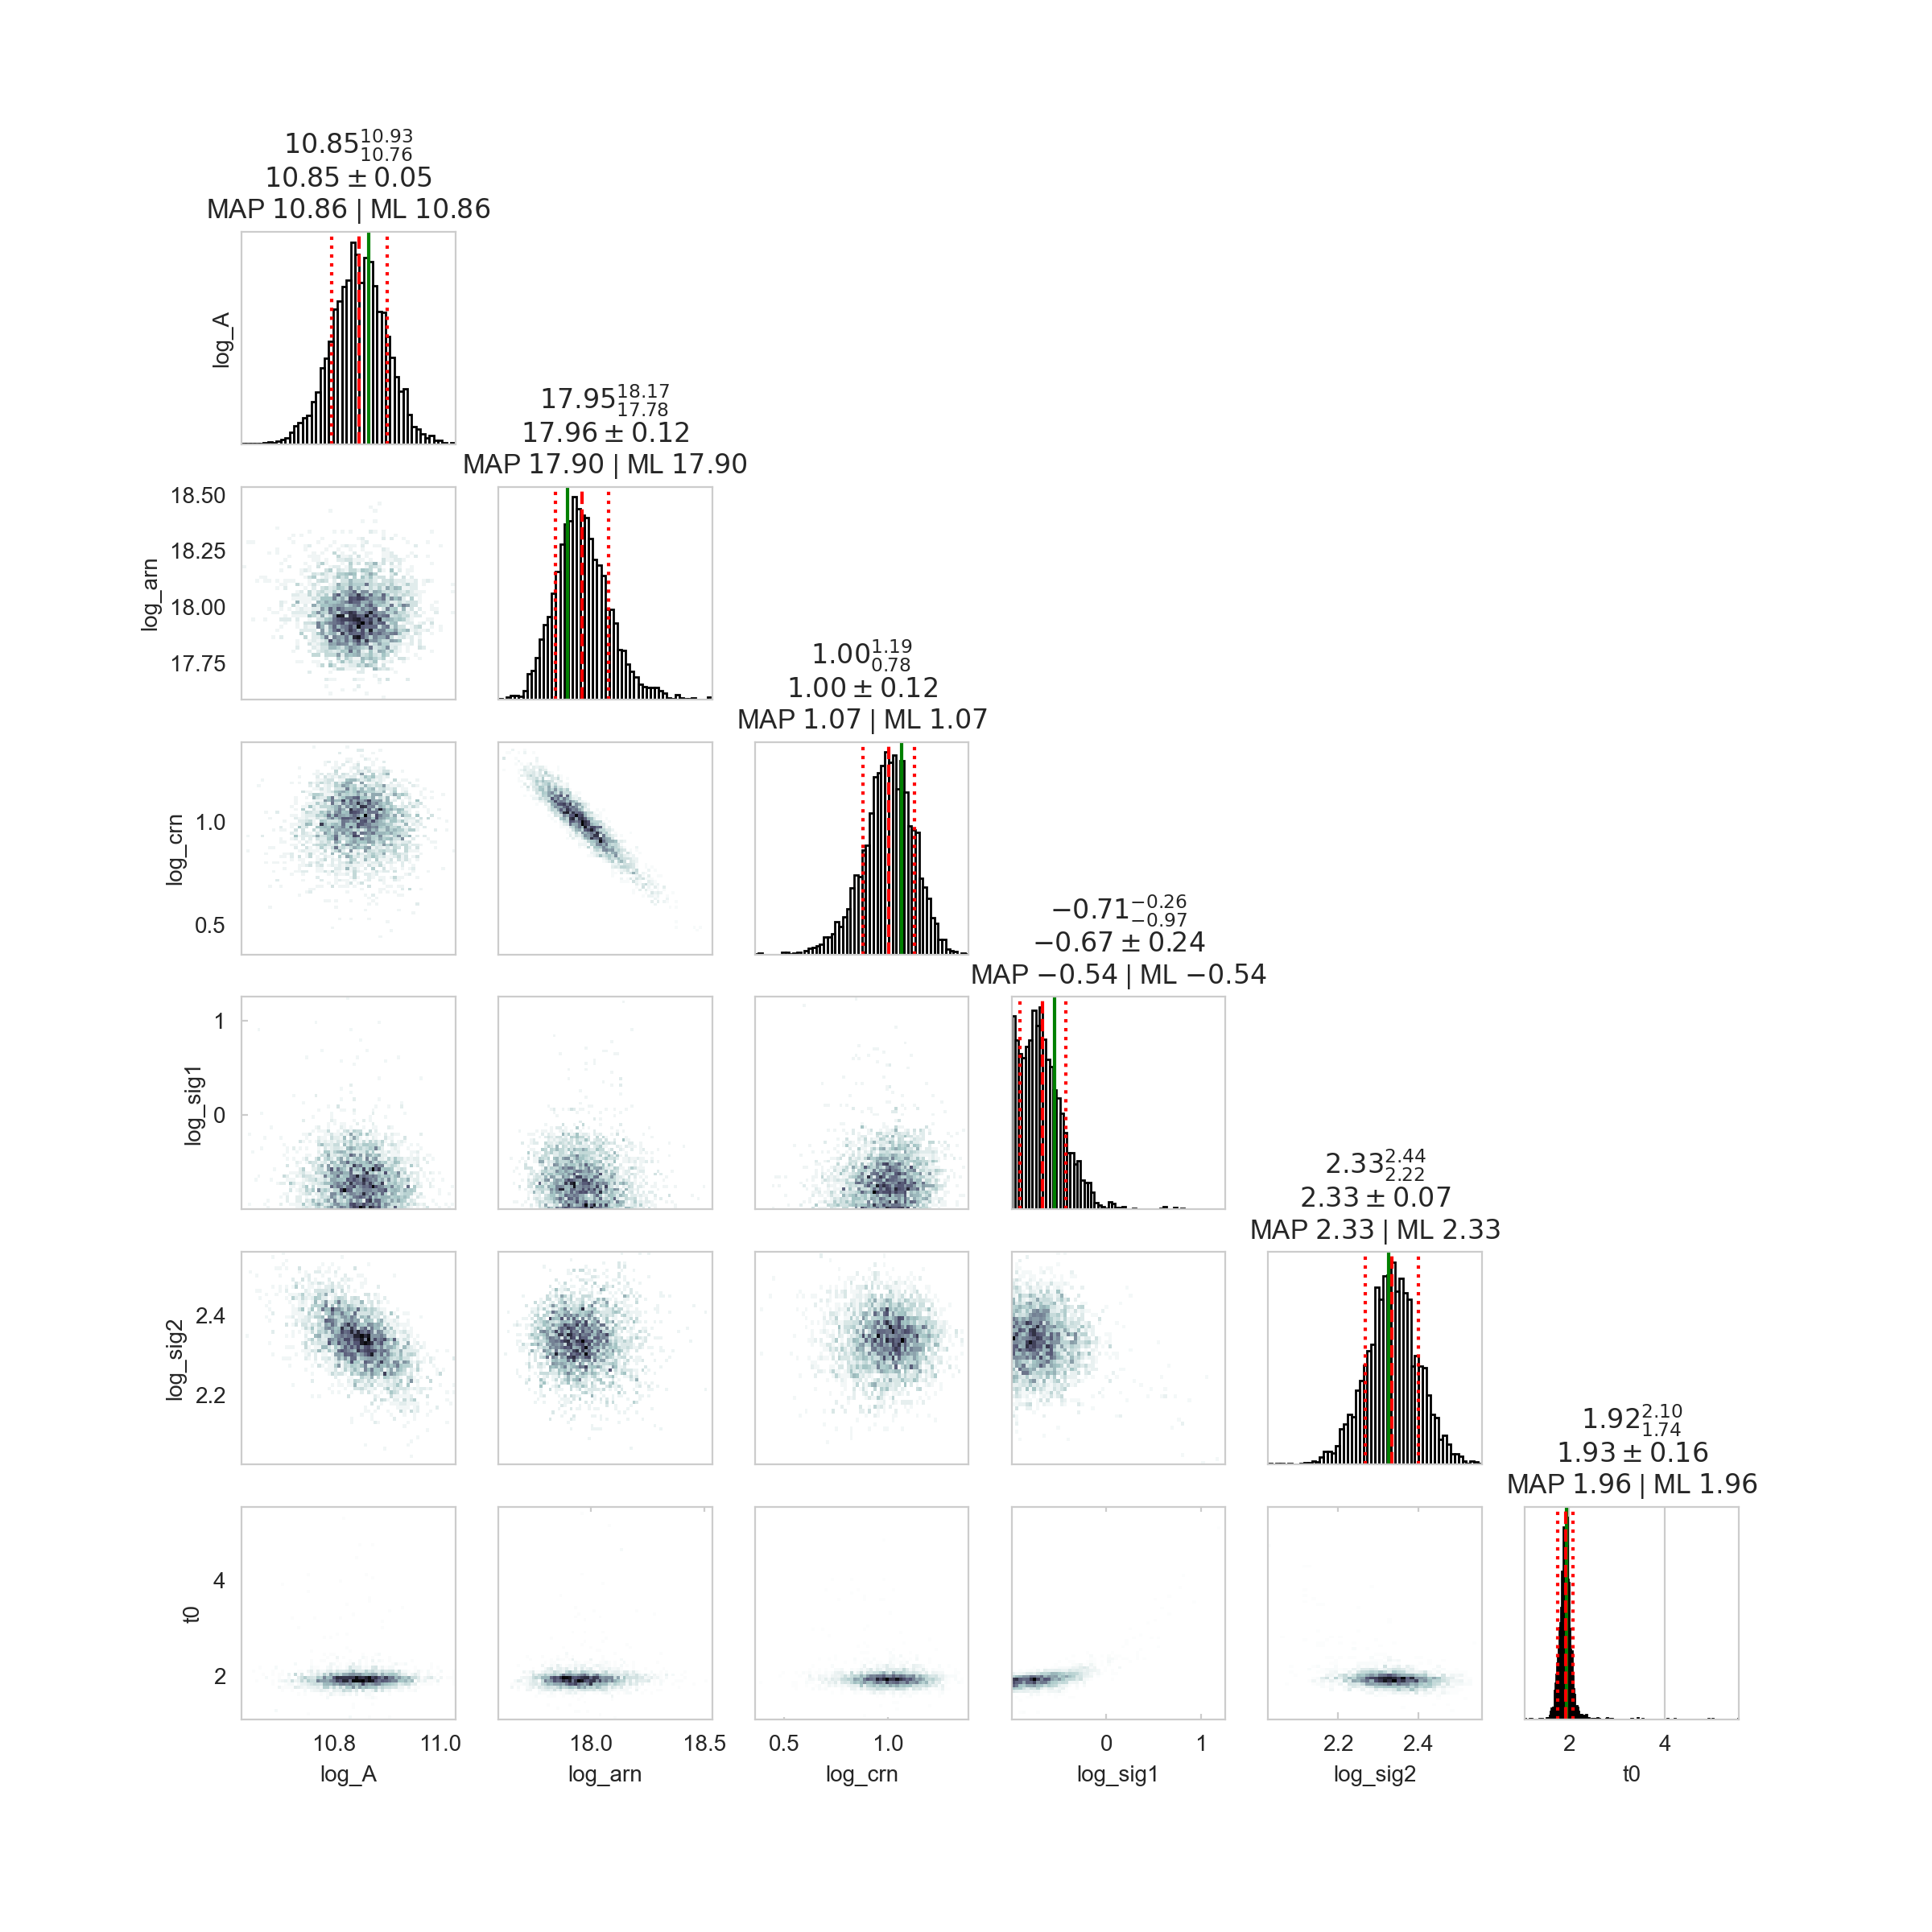

In [19]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

<IPython.core.display.Javascript object>


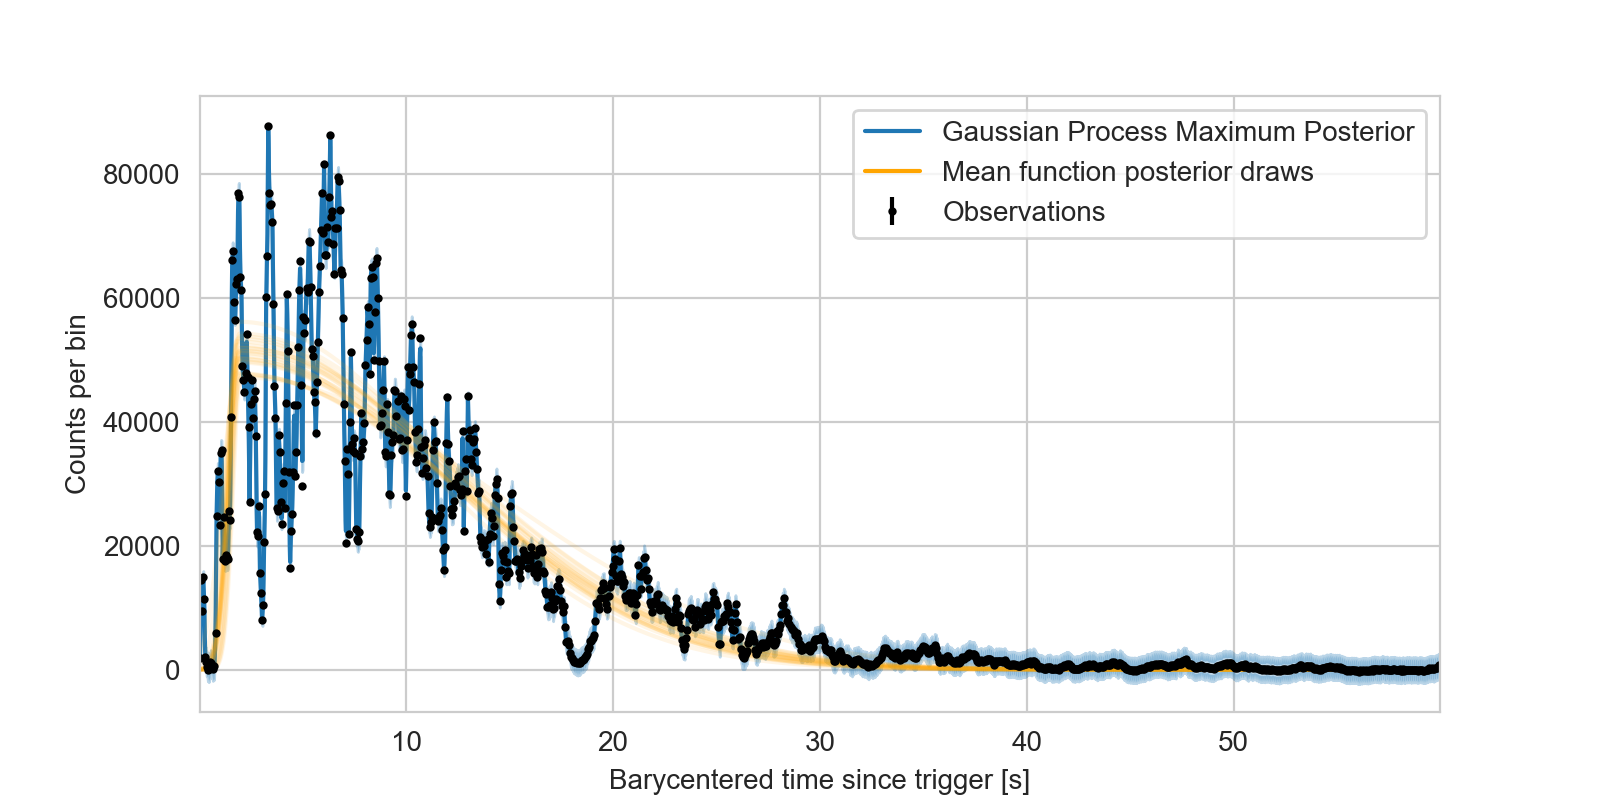

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_rn.results, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

### Simulate GRBs to Calibrate the FAP

Let's simulate a GRB from the results to calibrate the False Alarm Probability. There's a script that can do that.

## Red Noise + QPO

let's do a model with both red noise and a QPO:

In [24]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [25]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

        
# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(3.0)),
    "log_aqpo": tfpd.Uniform(2, 25),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [26]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=1500)

INFO[2023-10-25 08:12:21,522]: Sanity check...
INFO[2023-10-25 08:12:21,831]: Sanity check passed


Simulation Complete


In [27]:
print("log Evidence: ", gpresult_qporn.get_evidence())

log Evidence:  -11631.279312772167


In [28]:
print(f"log(Bayes factor): {gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()}")

log(Bayes factor): 8.520736108377605


In [29]:
with open(datadir+"intregal_drw_qpo_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

In [31]:
gpresult_qporn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 9048550
# samples: 57000
# slices: 1336500.0
# slices / acceptance: 27.0
# likelihood evals / sample: 158.7
# likelihood evals / slice: 6.7
--------
logZ=-11631.28 +- 0.14
H=12000.0
ESS=6558
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 10.846 +- 0.049 | 10.784 / 10.848 / 10.908 | 10.85 | 10.85
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 16.3 +- 1.1 | 15.5 / 16.0 / 18.4 | 16.1 | 16.1
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 17.83 +- 0.45 | 17.7 / 17.84 / 17.99 | 17.81 | 17.81
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -2.8 +- 1.5 | -5.6 / -2.4 / -1.4 | -2.8 | -2.8
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 1.05 +- 0.46 | 0.9 / 1.06 / 1.21 | 1

<IPython.core.display.Javascript object>


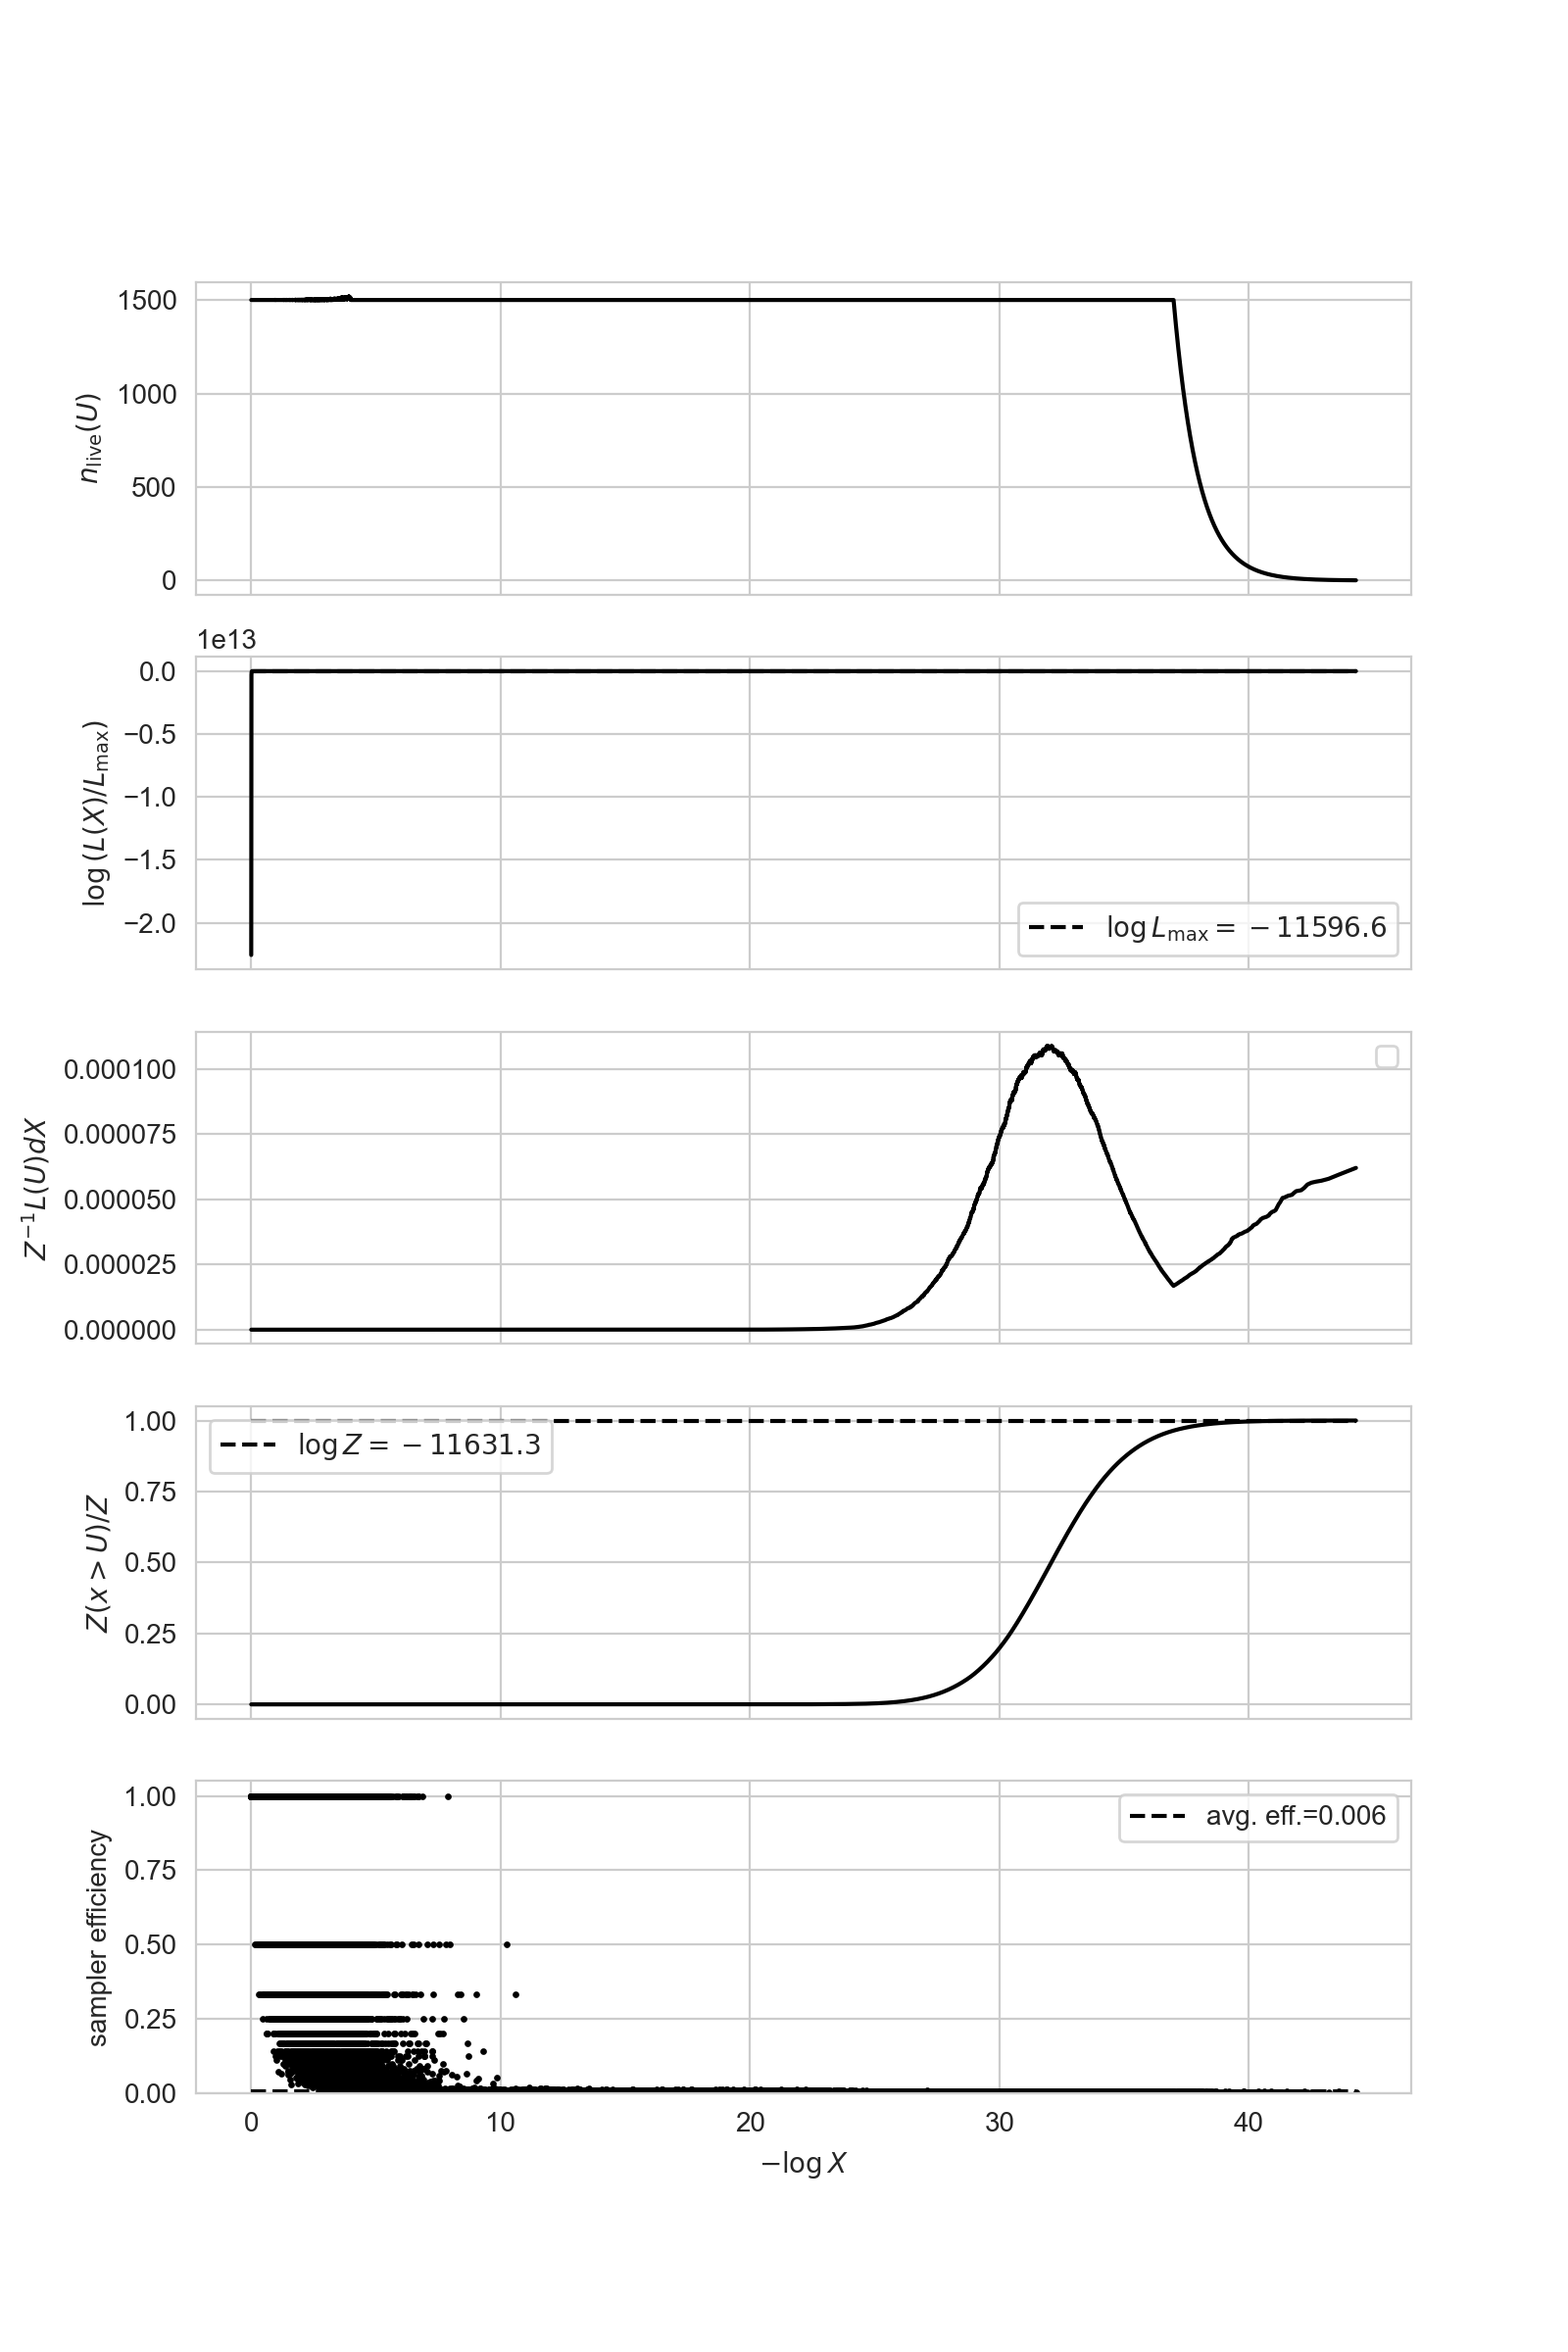

WARNING[2023-10-25 09:24:46,649]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [32]:
gpresult_qporn.exact_ns.plot_diagnostics(gpresult_qporn.results)

<IPython.core.display.Javascript object>


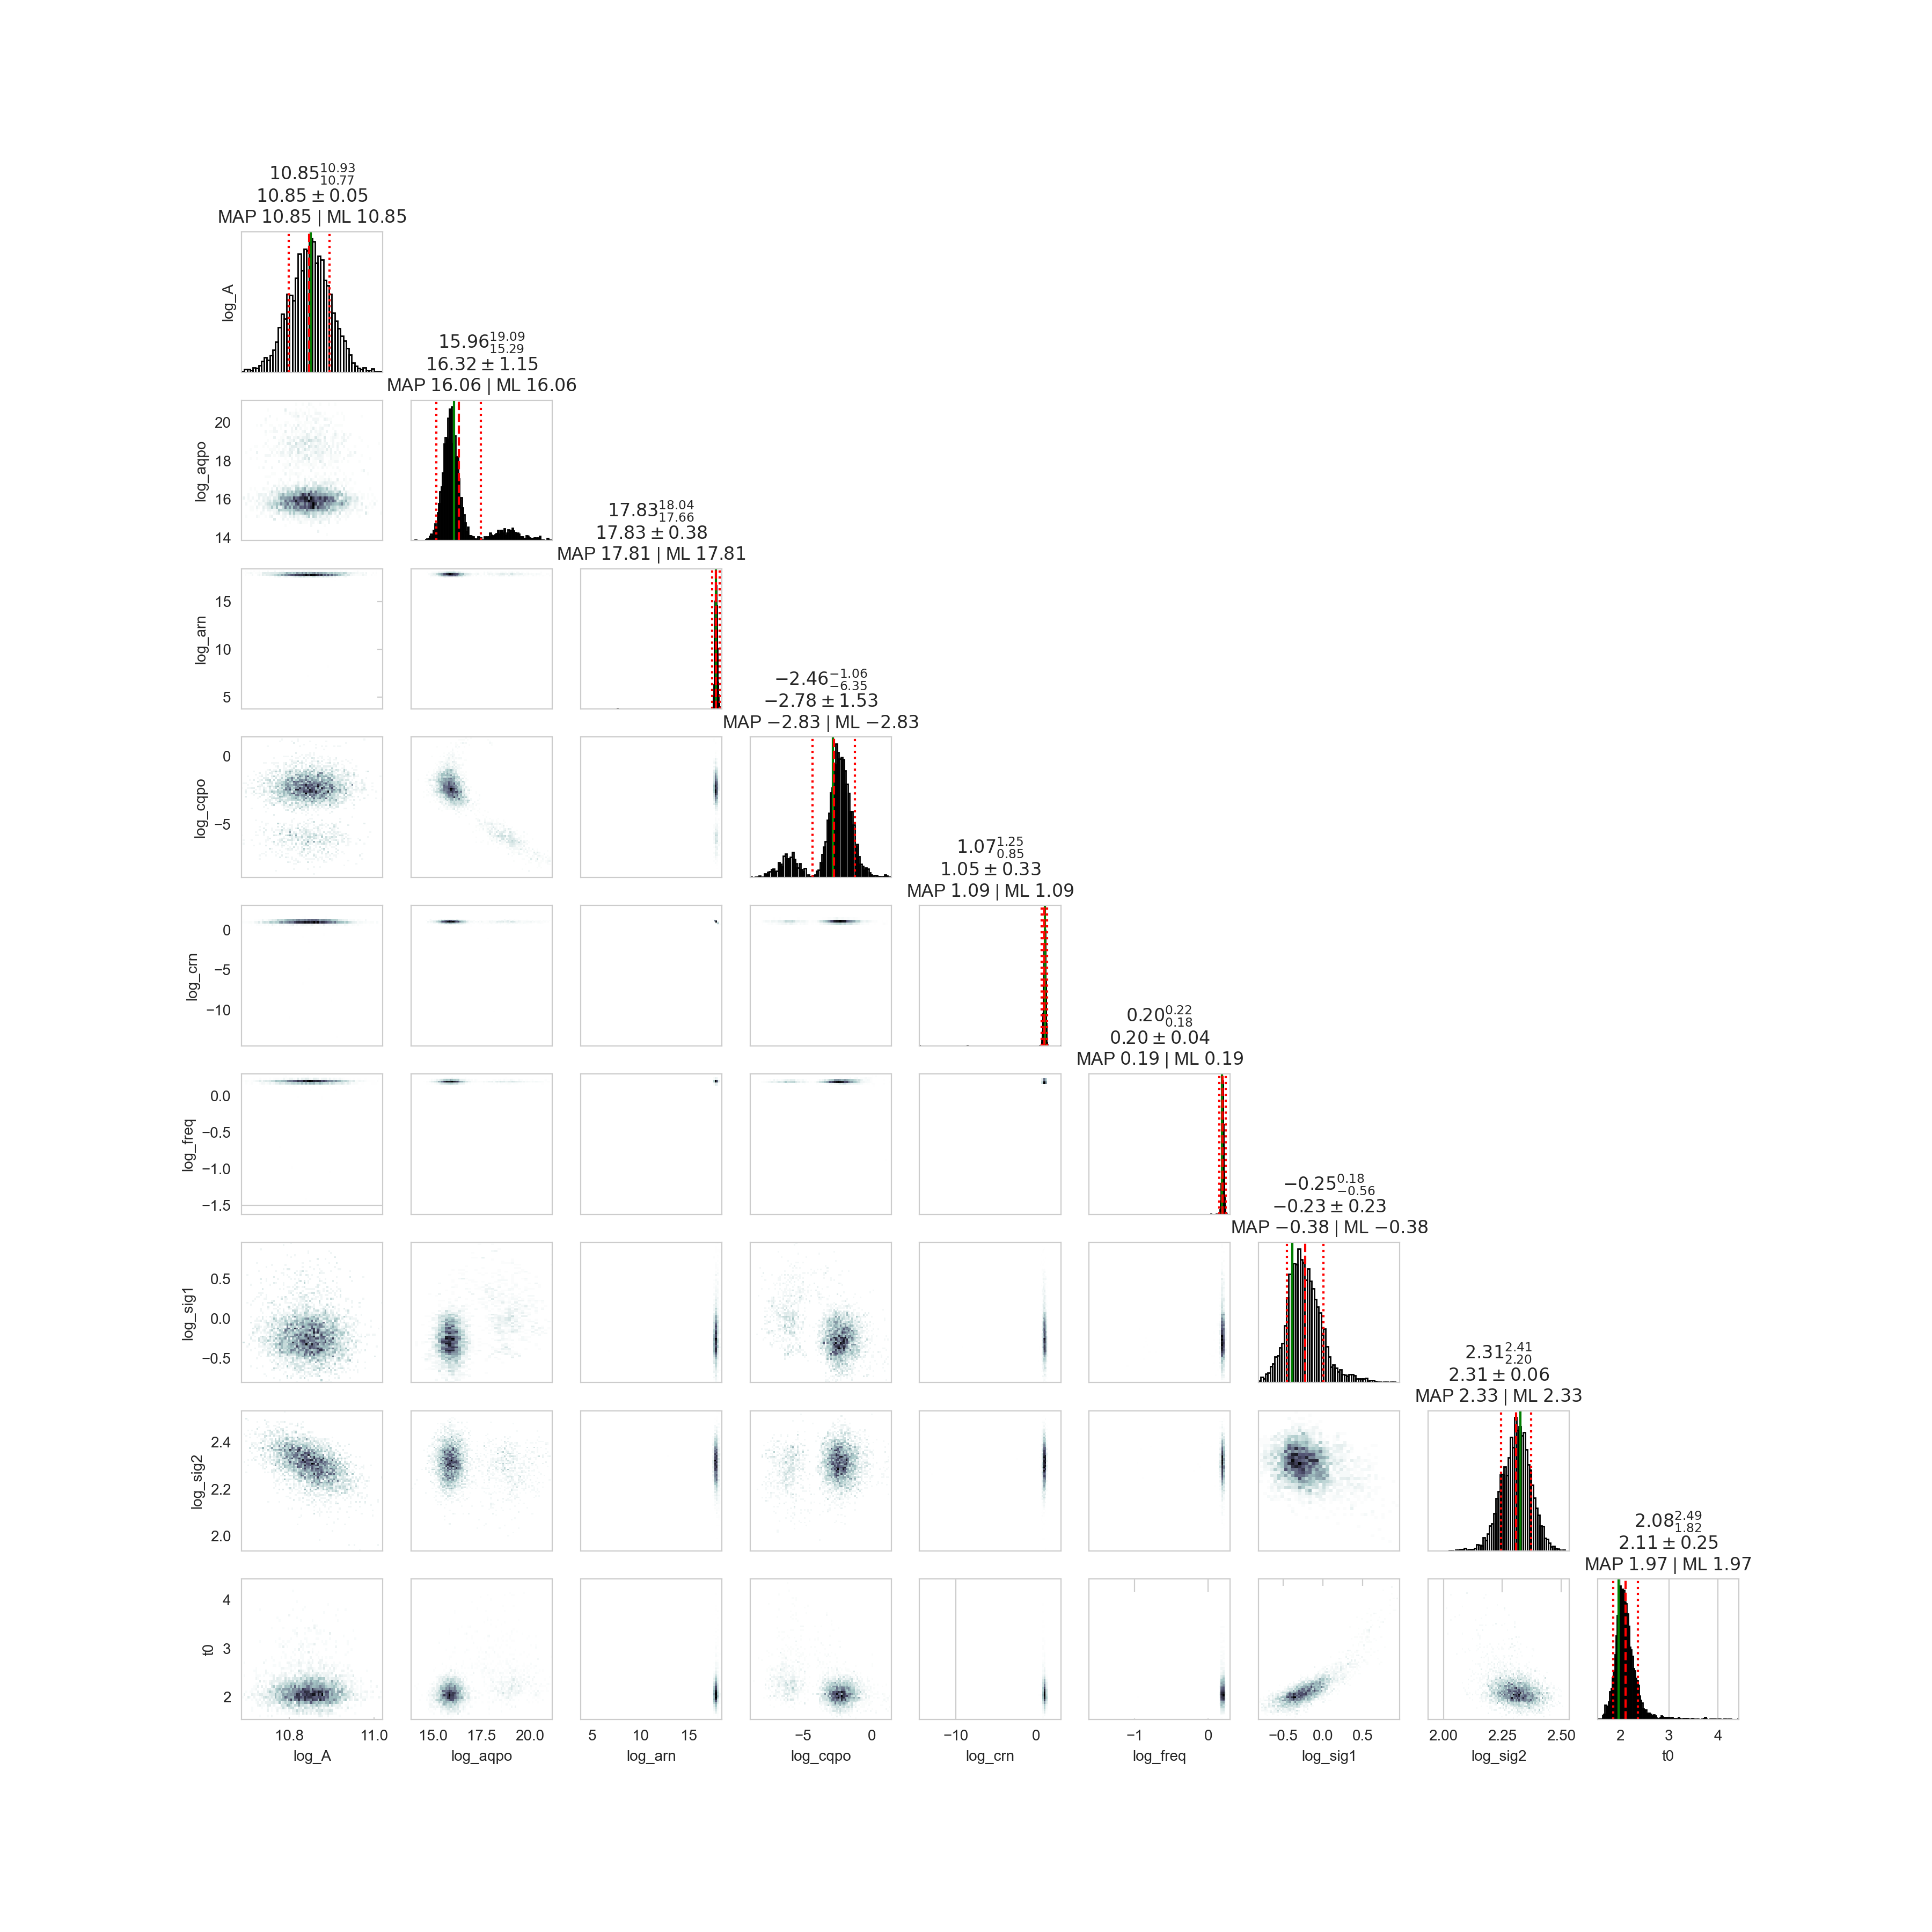

In [33]:
gpresult_qporn.plot_cornerplot()

<IPython.core.display.Javascript object>


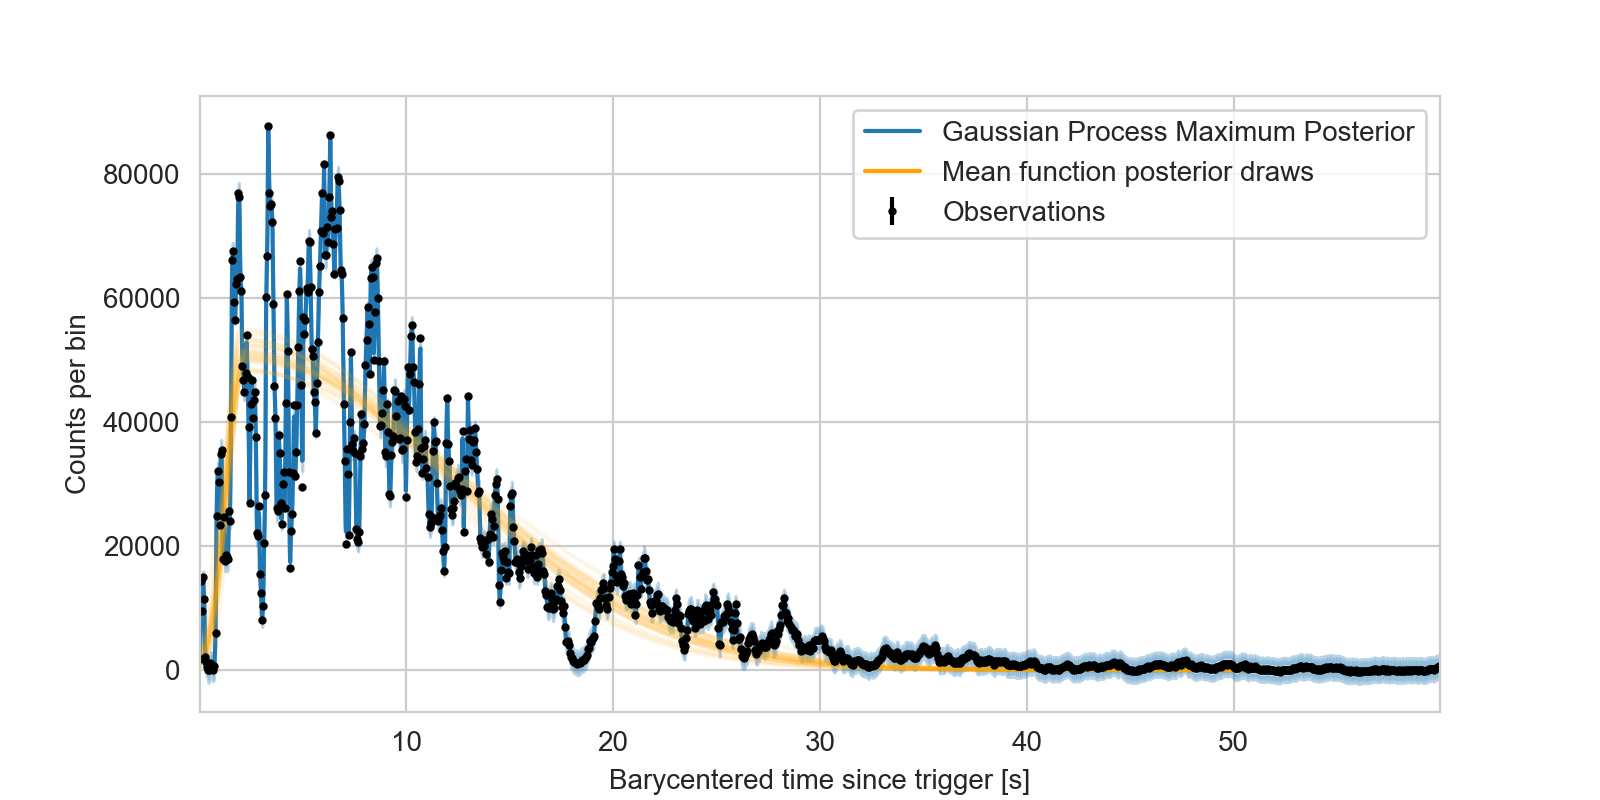

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_qporn.results, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [36]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1234)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

In [37]:
freq = np.exp(freq_resampled)
period = 1.0/freq

<IPython.core.display.Javascript object>


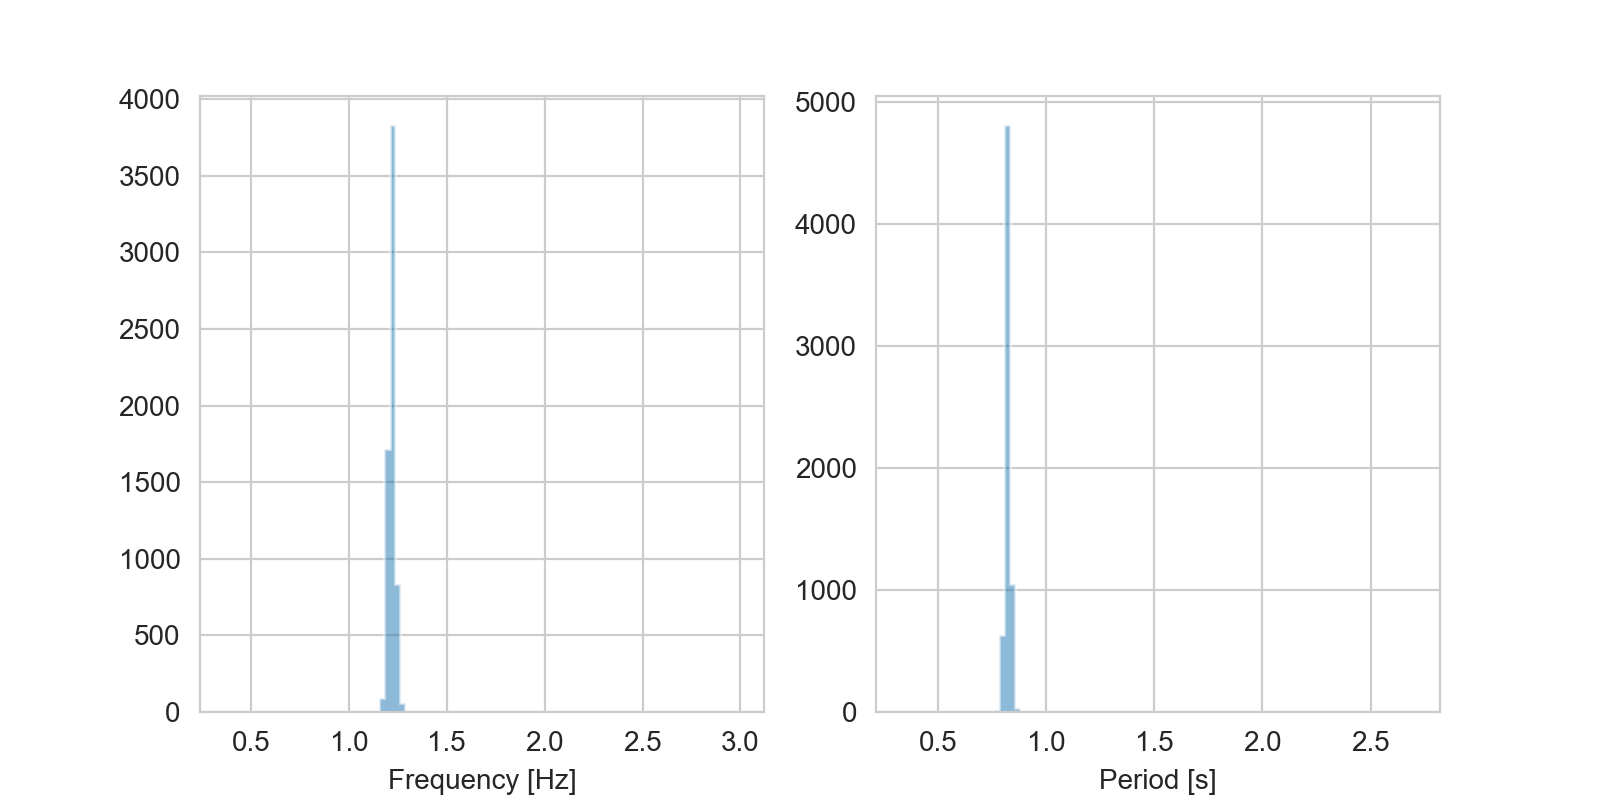

Text(0.5, 0, 'Period [s]')

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [39]:
np.log10(np.exp(gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()))

3.700508673622182

## INTEGRAL: Cutout

Let's cut out the same part of the light curve as we do for the Fermi/GBM data:

<IPython.core.display.Javascript object>


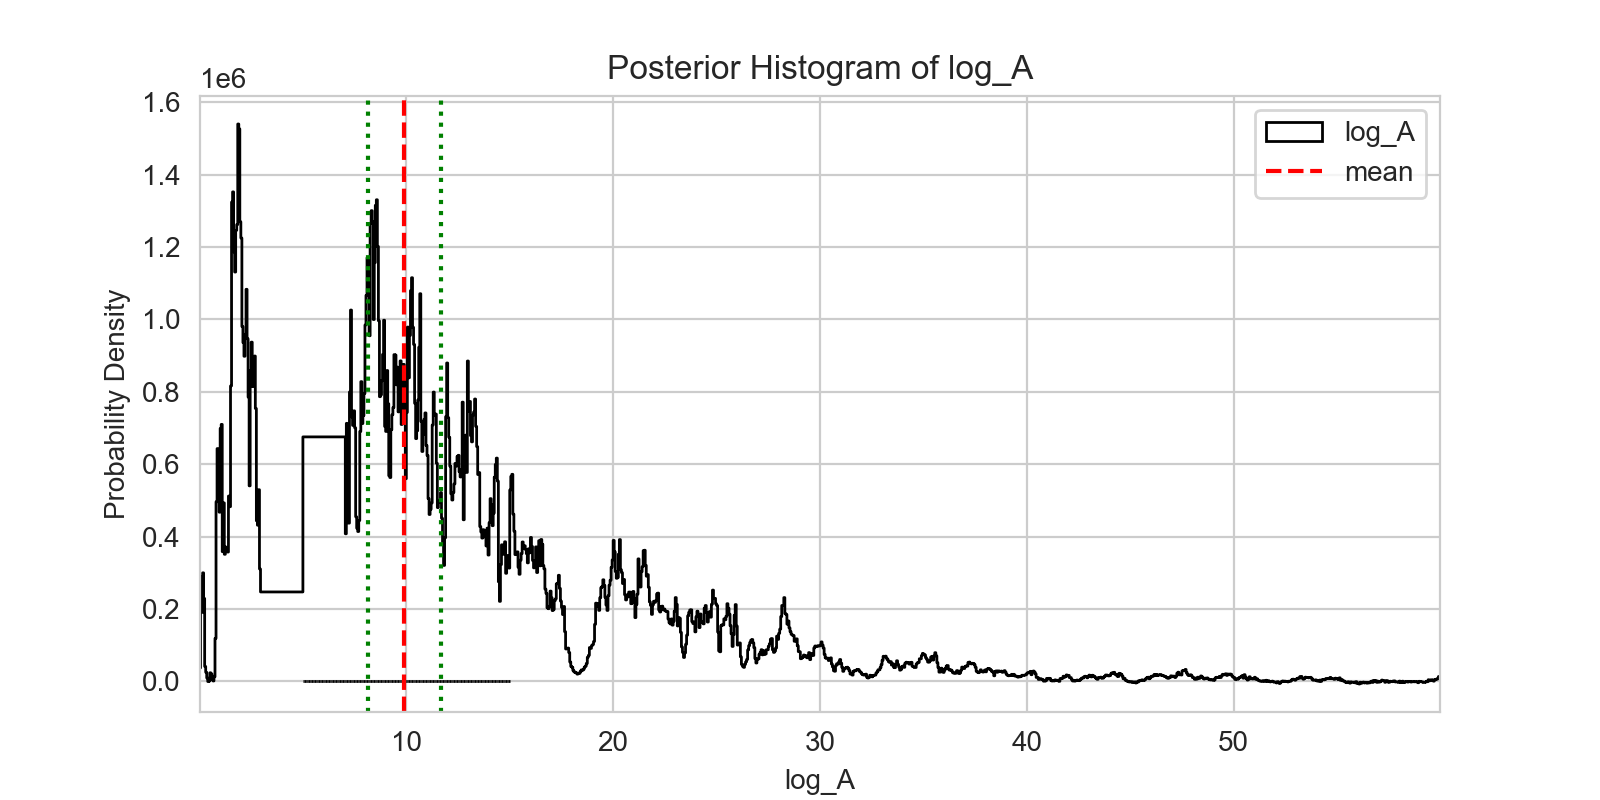

Text(0, 0.5, 'Countrate [counts/s]')

In [41]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

#lc = Lightcurve(barytime, counts-mean_bkg)
minind = barytime.searchsorted(0.0)
cutout_min = barytime.searchsorted(3.0)
cutout_max = barytime.searchsorted(7.0)
maxind = barytime.searchsorted(60.0)

t1 = barytime[minind:cutout_min]
t2 = barytime[cutout_max:maxind]
time = np.hstack([t1, t2])

c1 = counts[minind:cutout_min]
c2 = counts[cutout_max:maxind]
counts = np.hstack([c1, c2])

mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(time, counts-mean_bkg, dt=time[1]-time[0], skip_checks=True)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Countrate [counts/s]")


### DRW Only: Cutout

In [42]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [43]:
times = lc.time
counts = lc.counts

In [ ]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(np.log(0.1), np.log(3.0)),
    #"log_aqpo": tfpd.Uniform(2, 25),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [86]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn_cutout = GPResult(lc = lc)
gpresult_rn_cutout.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=2500)

INFO[2023-10-25 17:30:43,262]: Sanity check...
INFO[2023-10-25 17:30:43,268]: Sanity check passed


Simulation Complete


In [87]:
print("log Evidence: ", gpresult_rn_cutout.get_evidence())

log Evidence:  -10607.123589248387


In [88]:
with open(datadir+"intregal_drw_cutout_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn_cutout.results, f)

In [89]:
gpresult_rn_cutout.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 7958435
# samples: 67500
# slices: 1552500.0
# slices / acceptance: 27.0
# likelihood evals / sample: 117.9
# likelihood evals / slice: 5.1
--------
logZ=-10607.124 +- 0.091
H=11000.0
ESS=8193
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 10.711 +- 0.054 | 10.641 / 10.711 / 10.779 | 10.729 | 10.729
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 15.3 +- 4.6 | 6.3 / 17.4 / 17.5 | 2.2 | 2.2
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 8.2 +- 5.1 | 2.9 / 6.6 / 17.4 | 17.3 | 17.3
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: 0.7 +- 1.0 | -0.7 / 1.1 / 1.3 | -3.5 | -3.5
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 19.0 +- 15.0 | 1.0 / 23.0 / 37.0 | 1.0 | 1.0
--

<IPython.core.display.Javascript object>


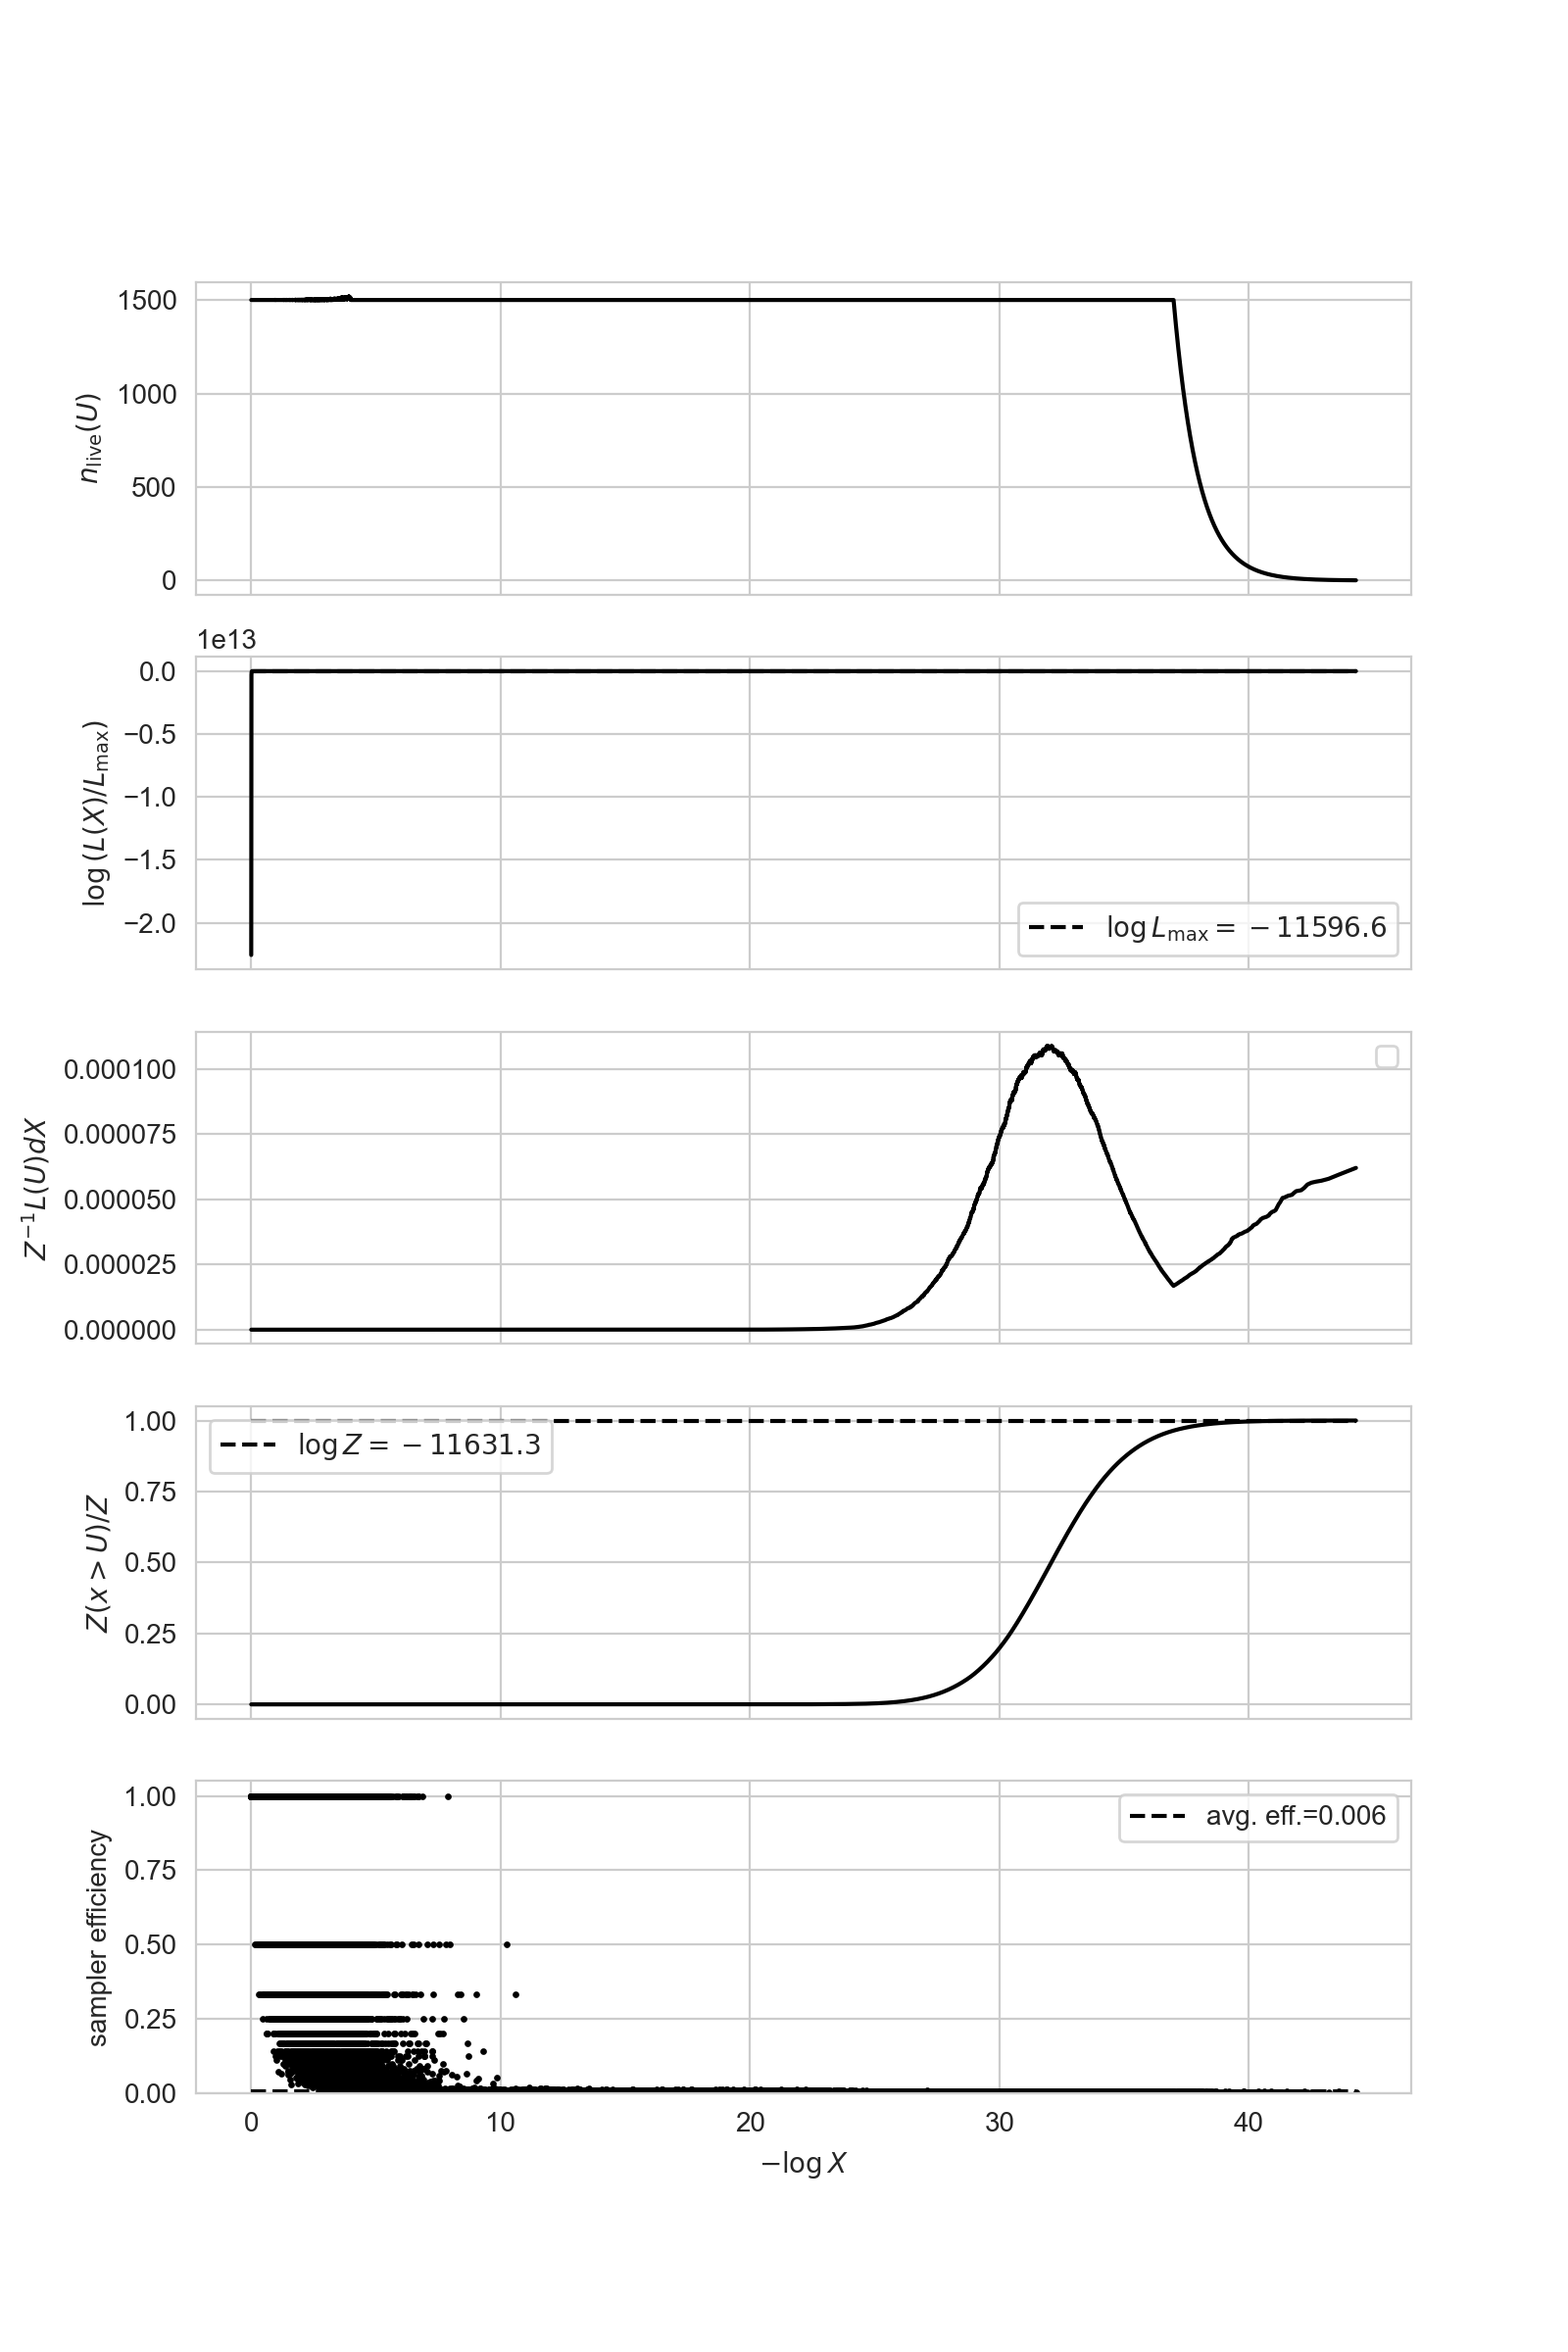

WARNING[2023-10-25 18:55:03,510]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [90]:
gpresult_rn_cutout.exact_ns.plot_diagnostics(gpresult_qporn.results)

<IPython.core.display.Javascript object>


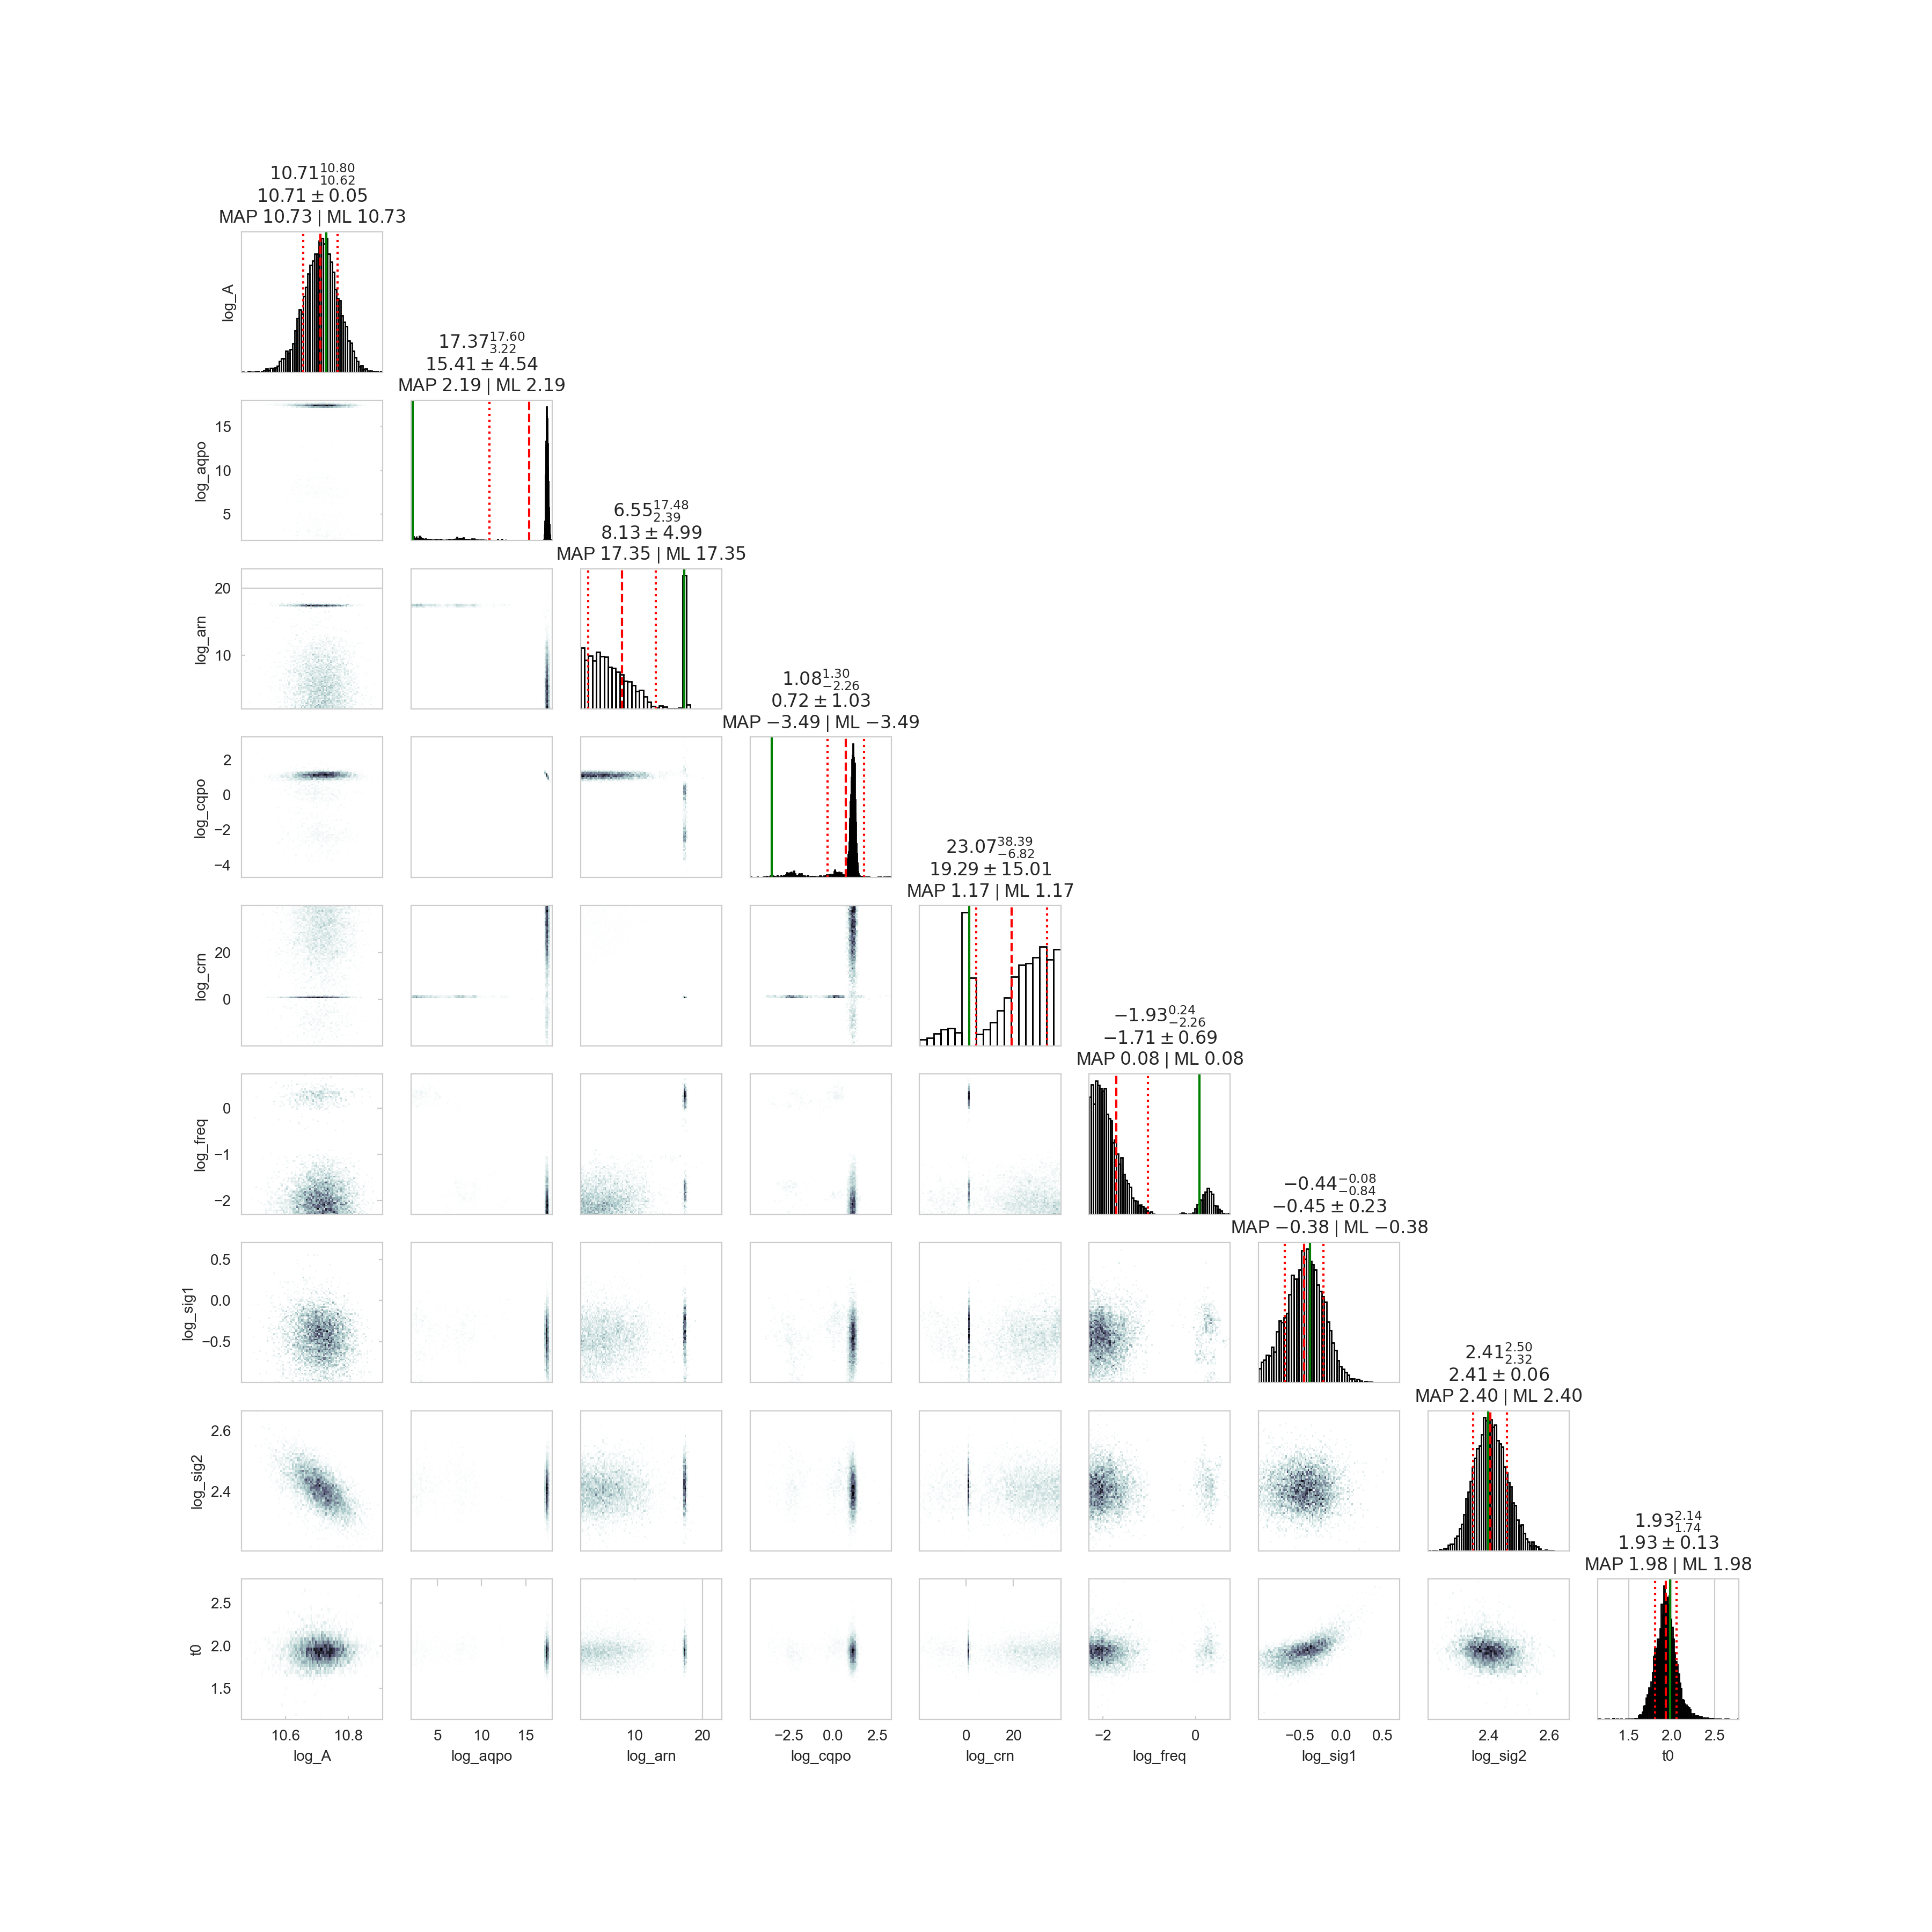

In [92]:
gpresult_rn_cutout.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

<IPython.core.display.Javascript object>


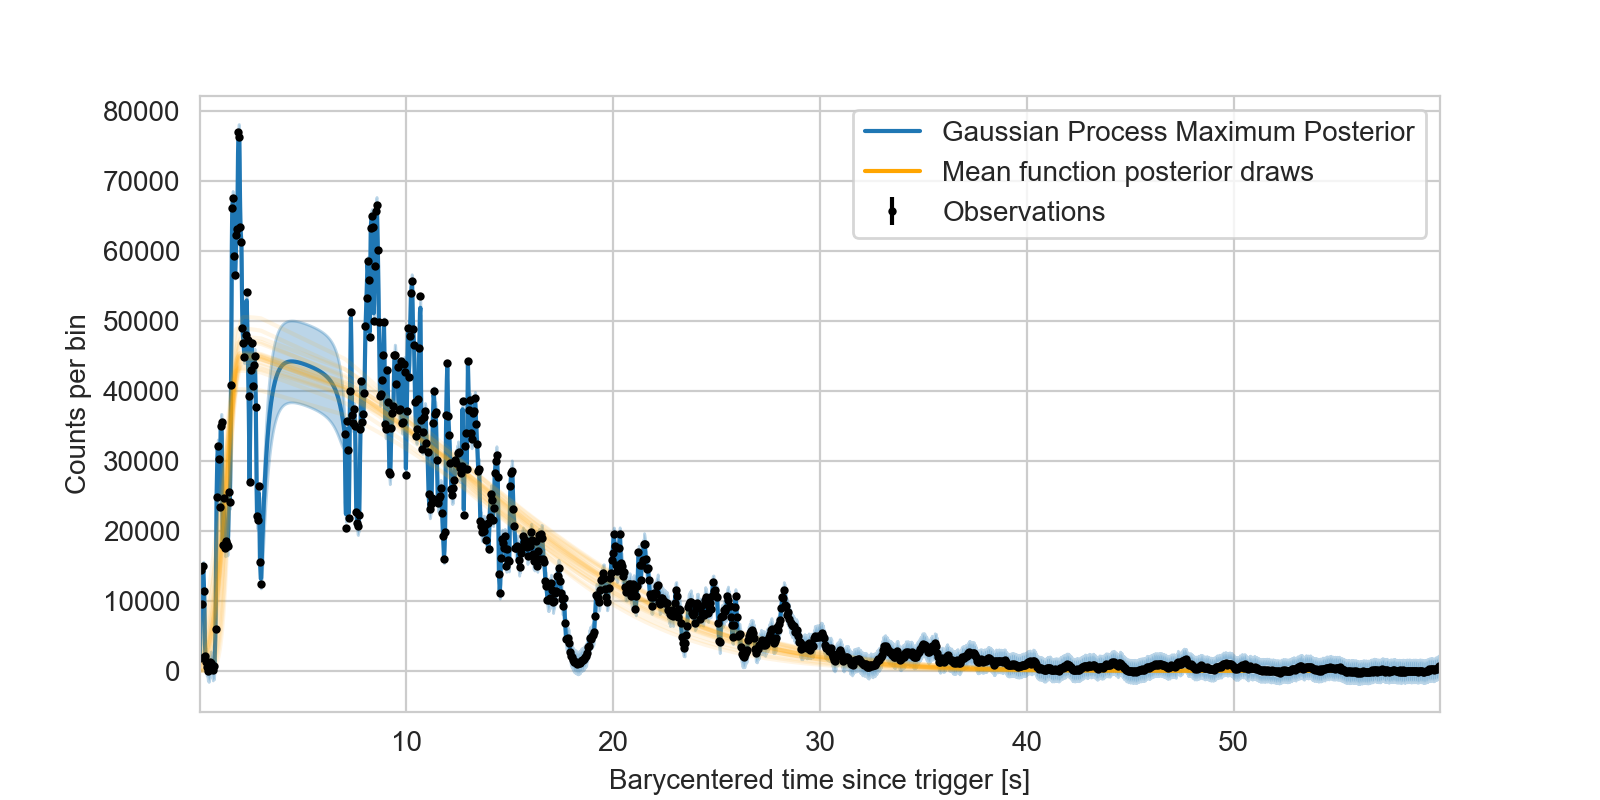

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_rn_cutout.results, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

### Cutout: Red Noise + QPO

let's do a model with both red noise and a QPO:

In [55]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [94]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 20),
    "log_cqpo": tfpd.Uniform(-5, 5),
    "log_arn": tfpd.Uniform(2, 40),
    "log_crn": tfpd.Uniform(-20, 40)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [95]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn_cutout = GPResult(lc = lc)
gpresult_qporn_cutout.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=2000)

INFO[2023-10-25 18:56:11,017]: Sanity check...
INFO[2023-10-25 18:56:11,024]: Sanity check passed


Simulation Complete


In [96]:
print("log Evidence: ", gpresult_rn_cutout.get_evidence())

log Evidence:  -10607.123589248387


In [97]:
print("log Evidence: ", gpresult_qporn_cutout.get_evidence())

log Evidence:  -10597.919910934423


In [98]:
gpresult_qporn_cutout.get_evidence() - gpresult_rn_cutout.get_evidence()

Array(9.20367831, dtype=float64)

In [99]:
with open(datadir+"intregal_drw_qpo_cutout_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn_cutout.results, f)

In [100]:
gpresult_qporn_cutout.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 10183343
# samples: 70000
# slices: 1620000.0
# slices / acceptance: 27.0
# likelihood evals / sample: 145.5
# likelihood evals / slice: 6.2
--------
logZ=-10597.92 +- 0.12
H=11000.0
ESS=7552
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 10.701 +- 0.059 | 10.626 / 10.703 / 10.775 | 10.721 | 10.721
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 14.43 +- 0.65 | 13.62 / 14.43 / 15.27 | 14.63 | 14.63
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 17.44 +- 0.14 | 17.28 / 17.43 / 17.62 | 17.37 | 17.37
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -3.7 +- 0.57 | -4.44 / -3.7 / -2.97 | -4.12 | -4.12
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 1.0 +- 0.15 | 0.81 /

<IPython.core.display.Javascript object>


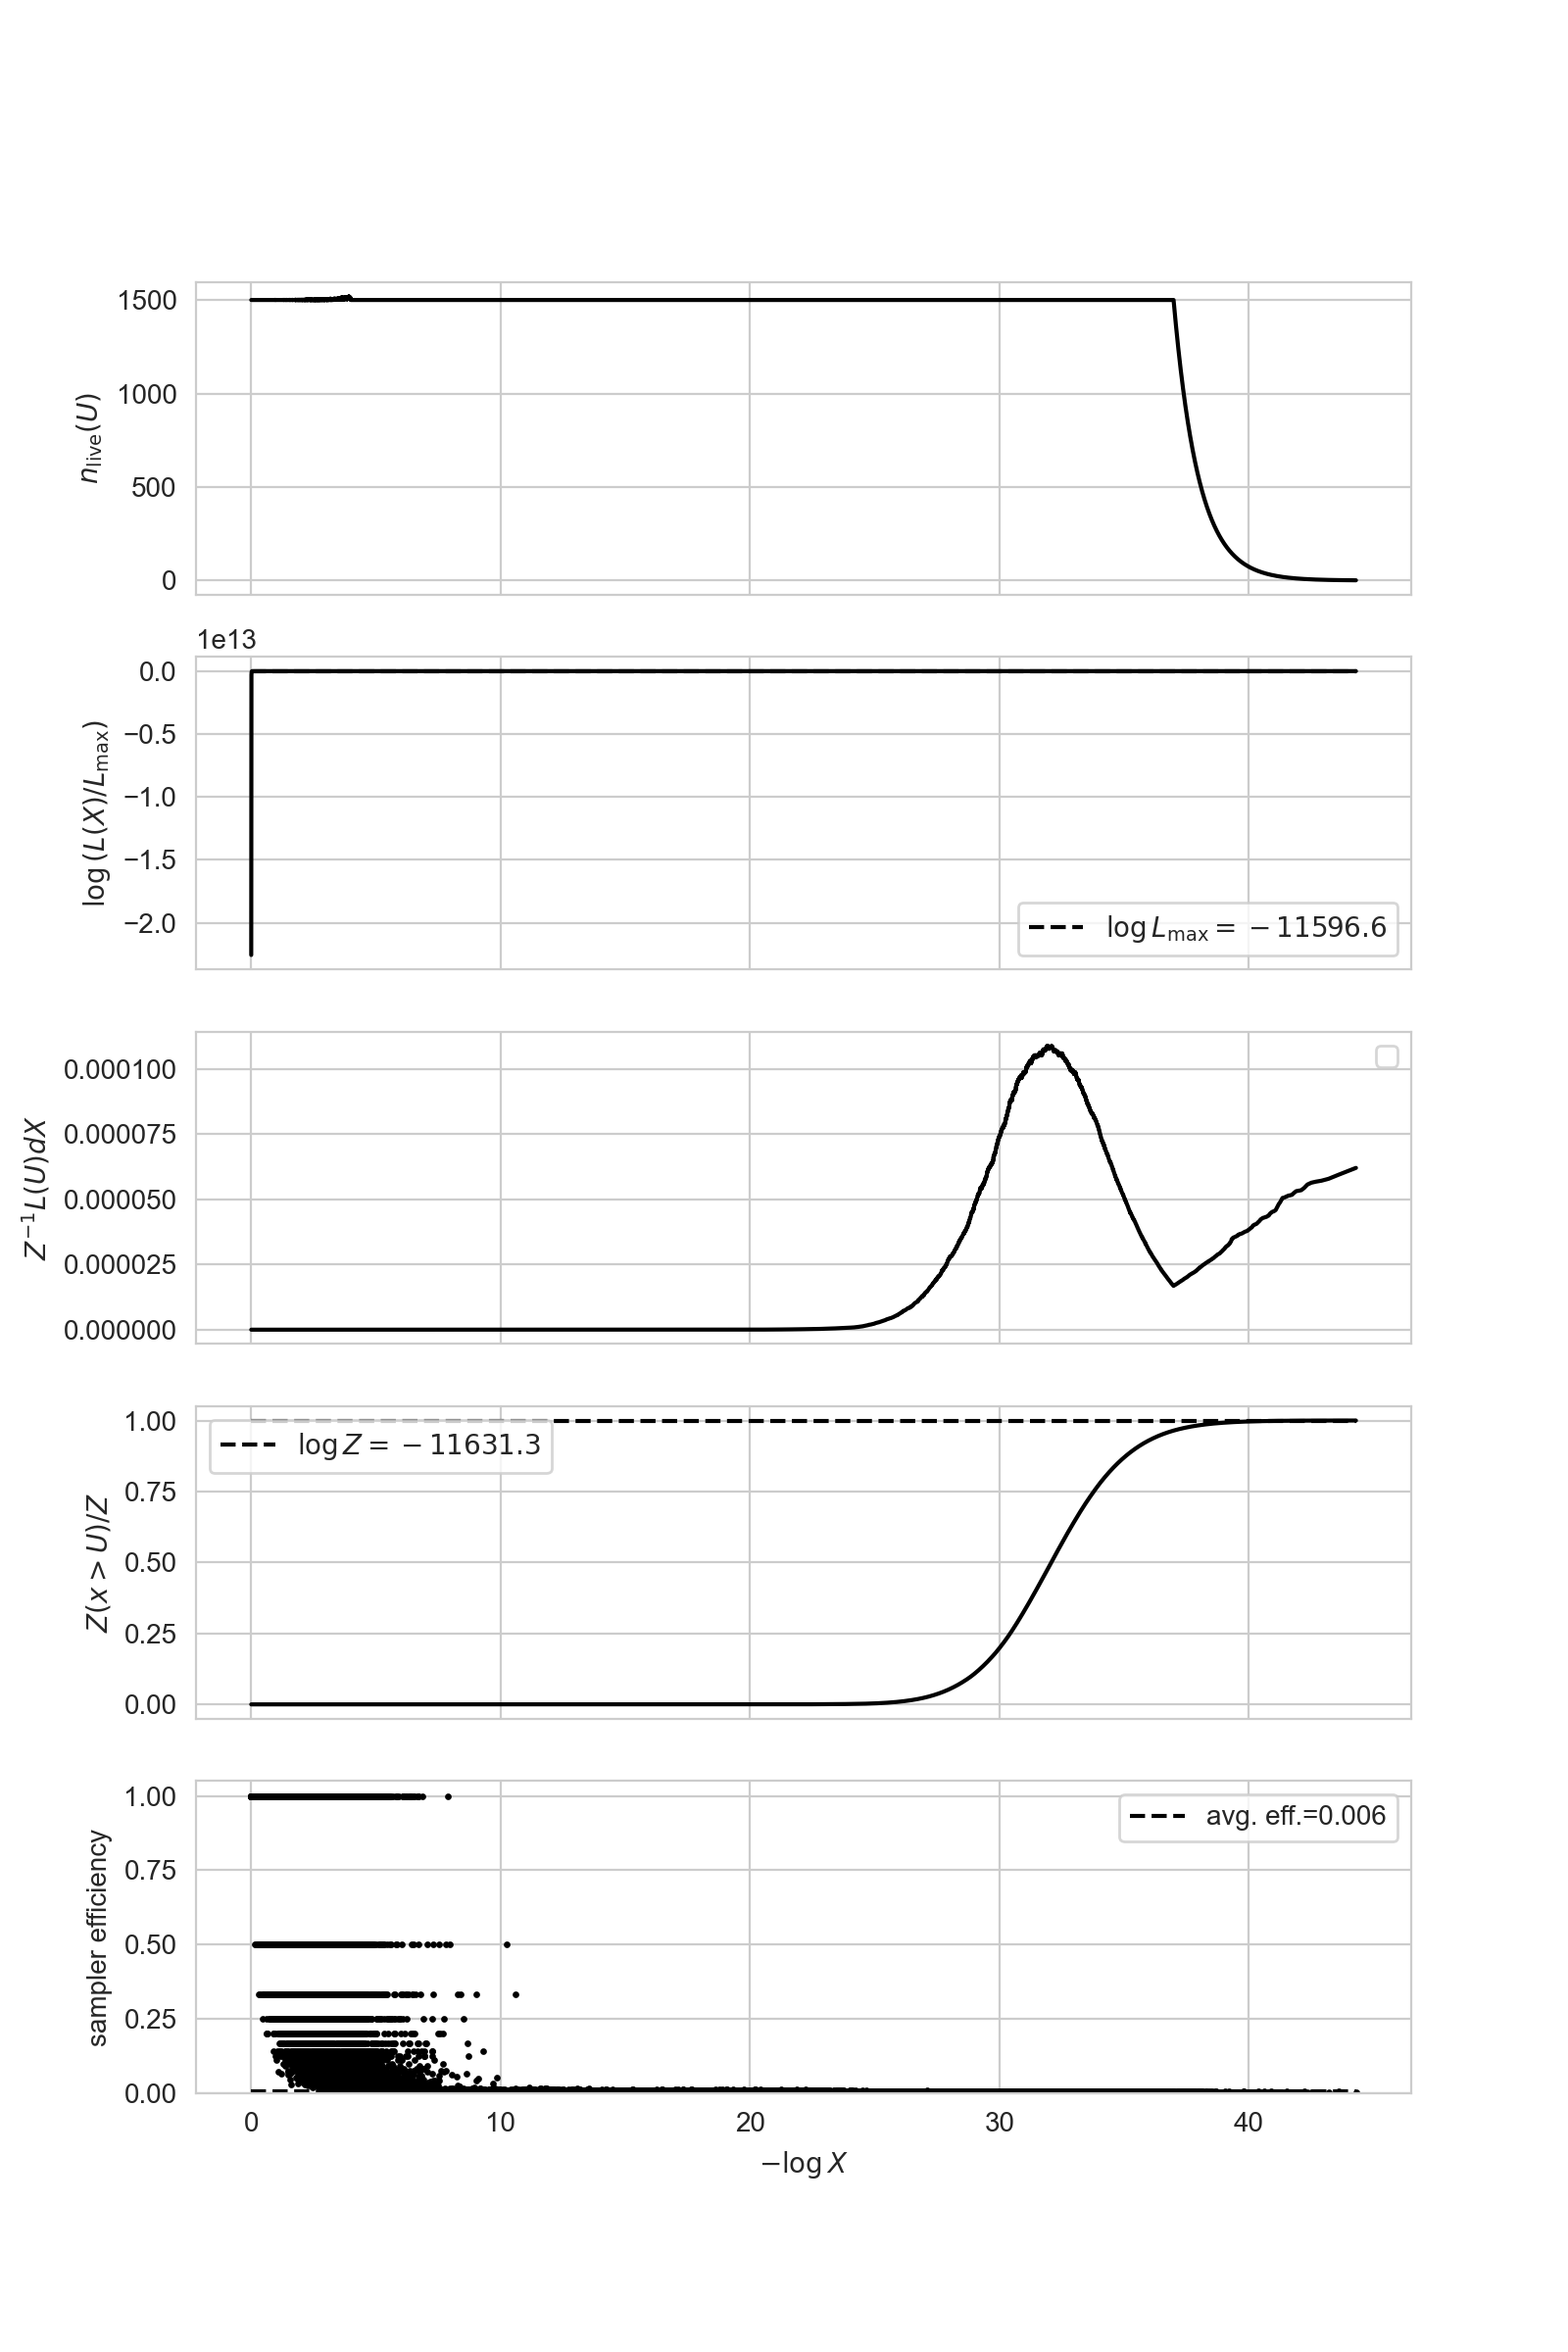

WARNING[2023-10-25 19:42:30,663]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [101]:
gpresult_qporn_cutout.exact_ns.plot_diagnostics(gpresult_qporn.results)

<IPython.core.display.Javascript object>


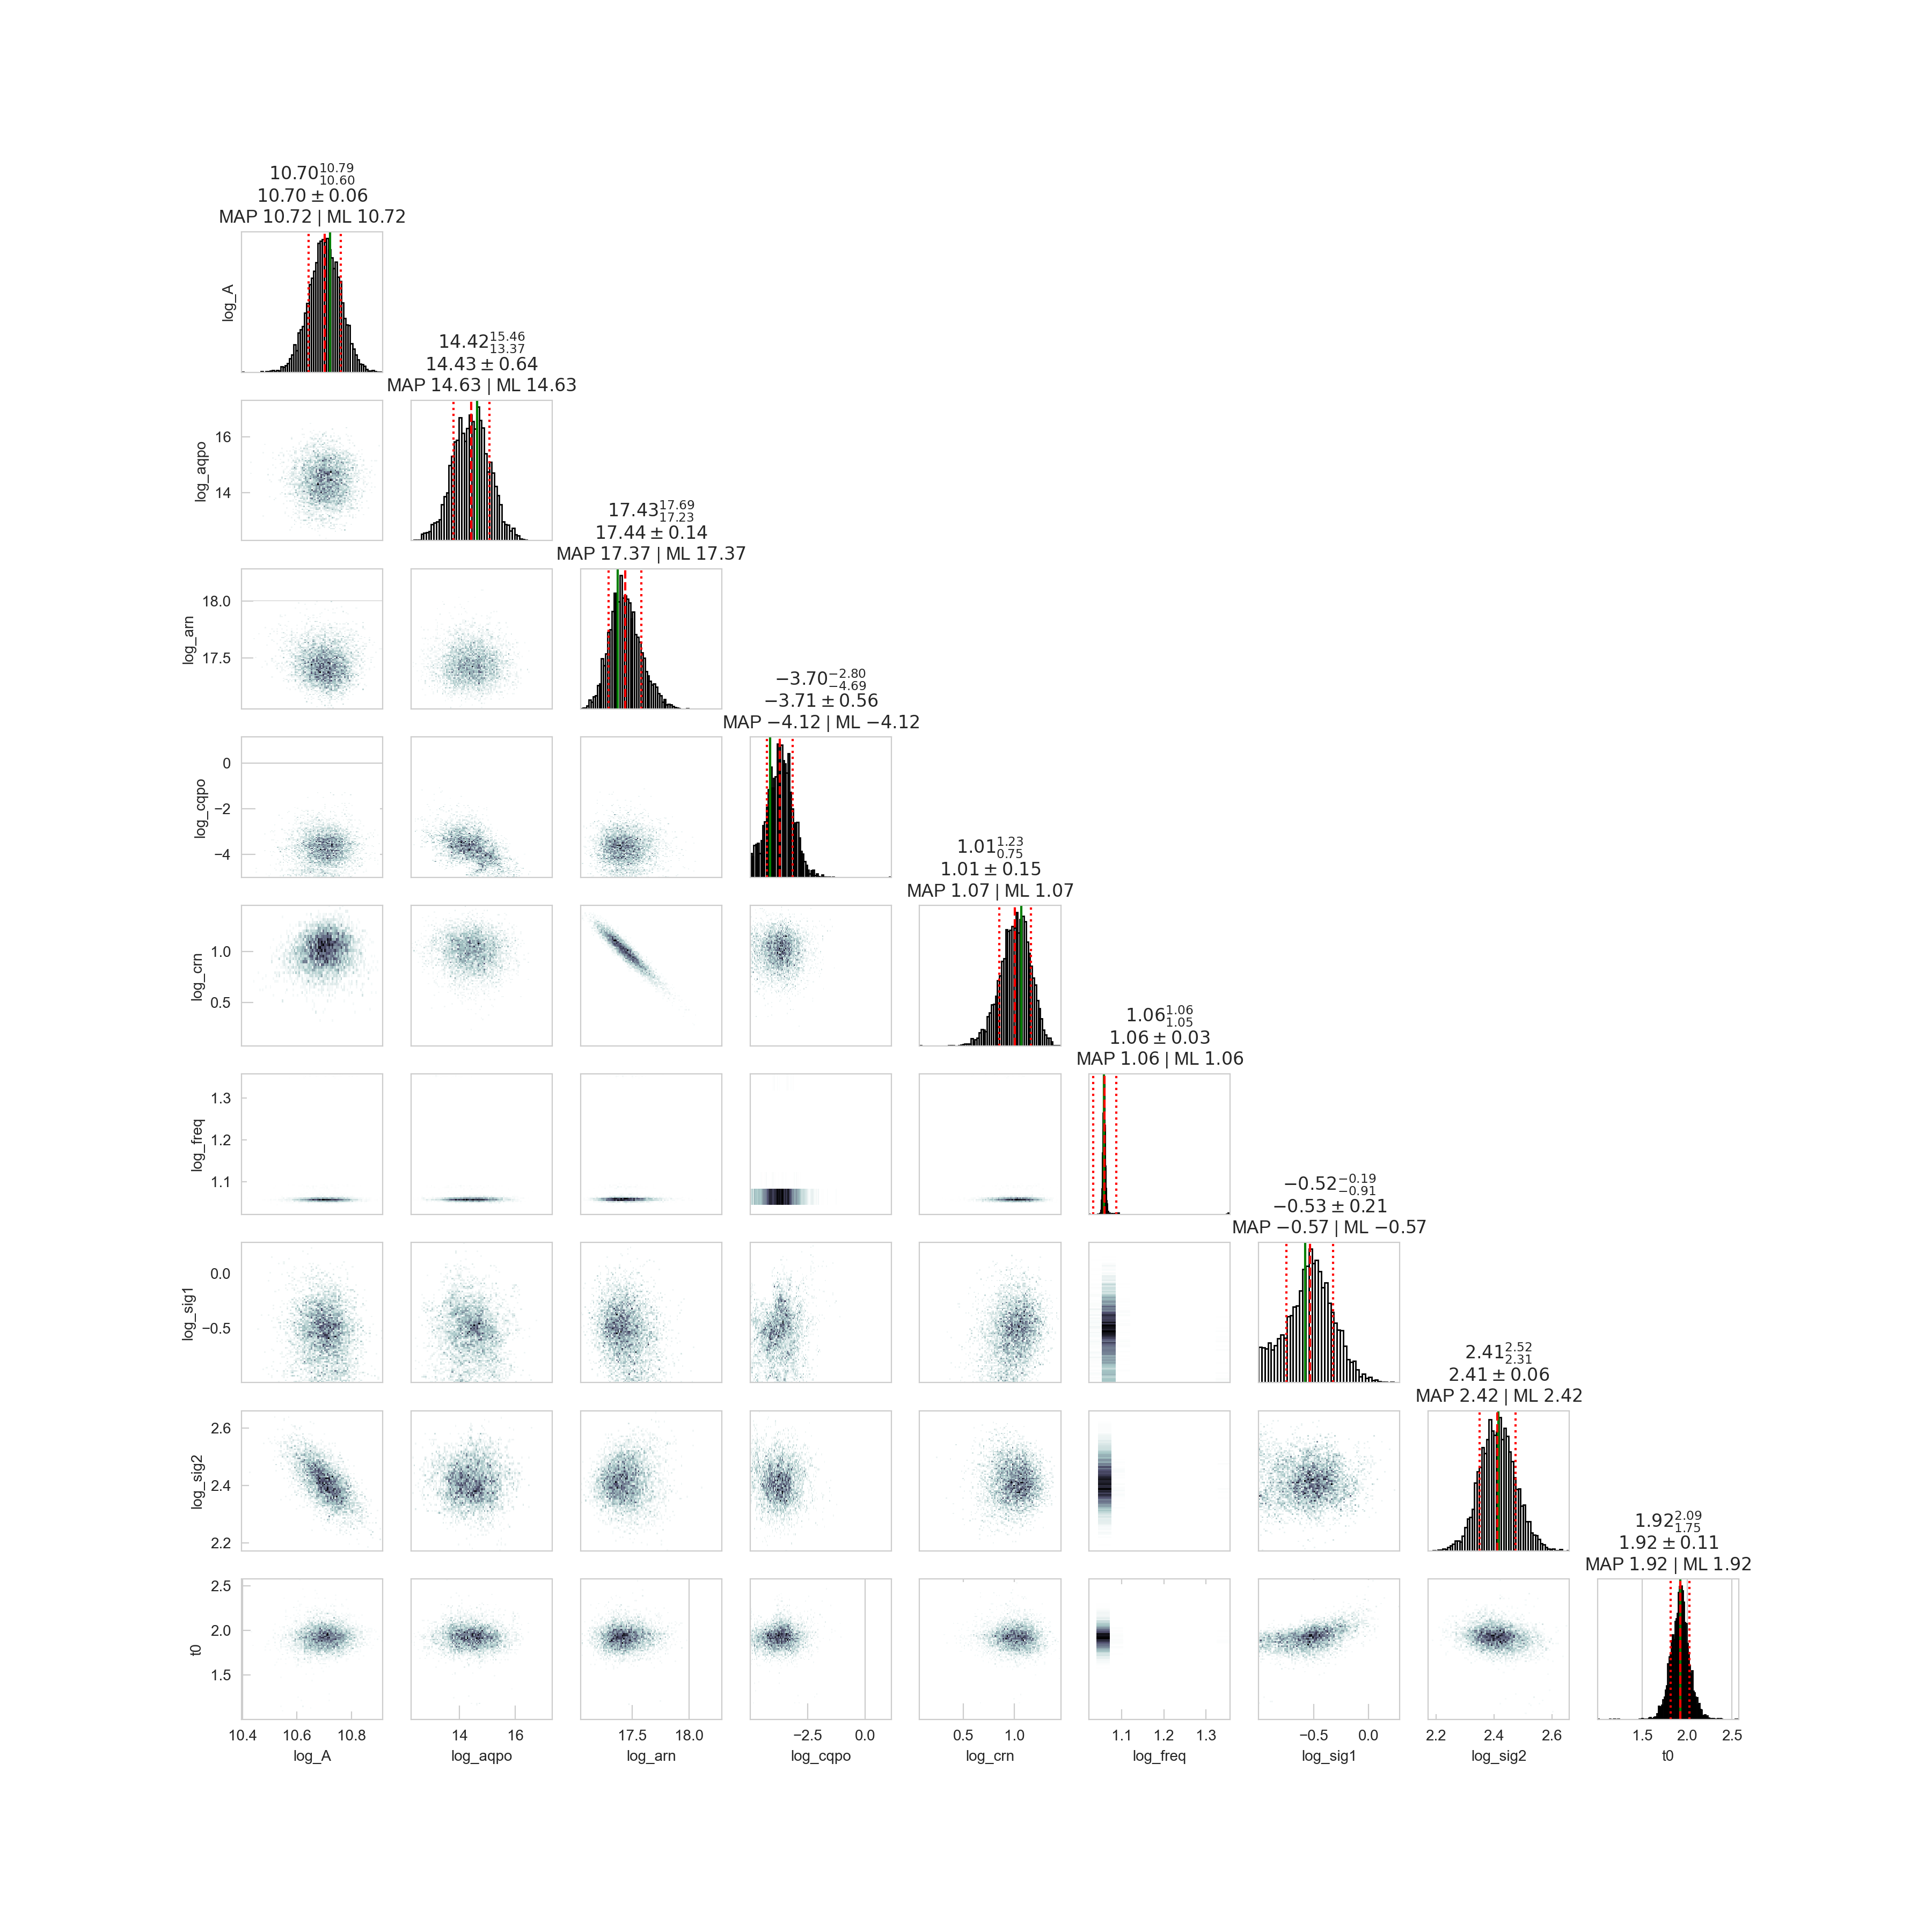

In [102]:
gpresult_qporn_cutout.plot_cornerplot()

<IPython.core.display.Javascript object>


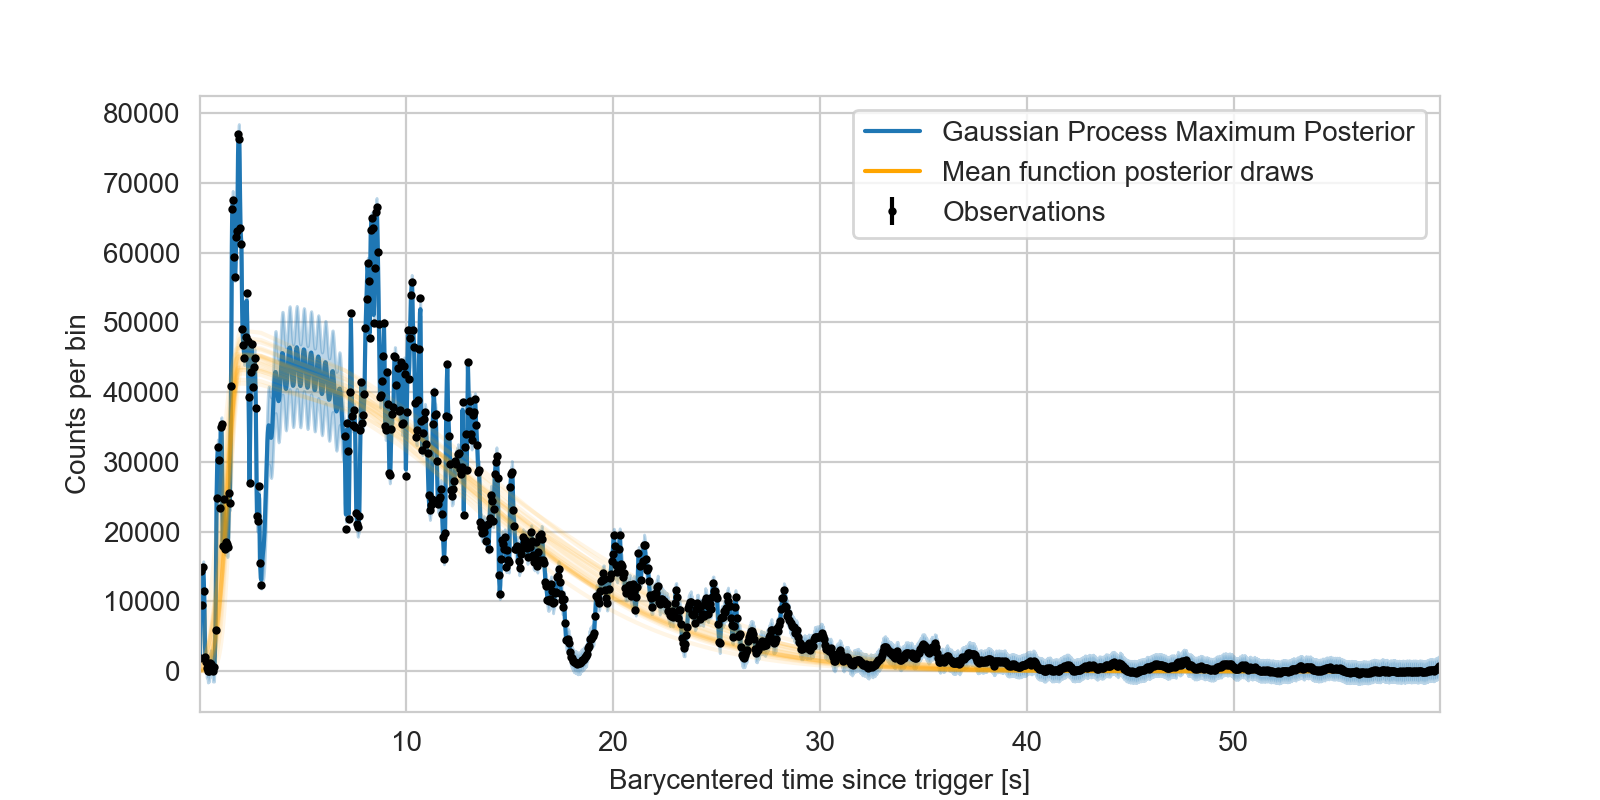

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_qporn_cutout.results, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

<IPython.core.display.Javascript object>


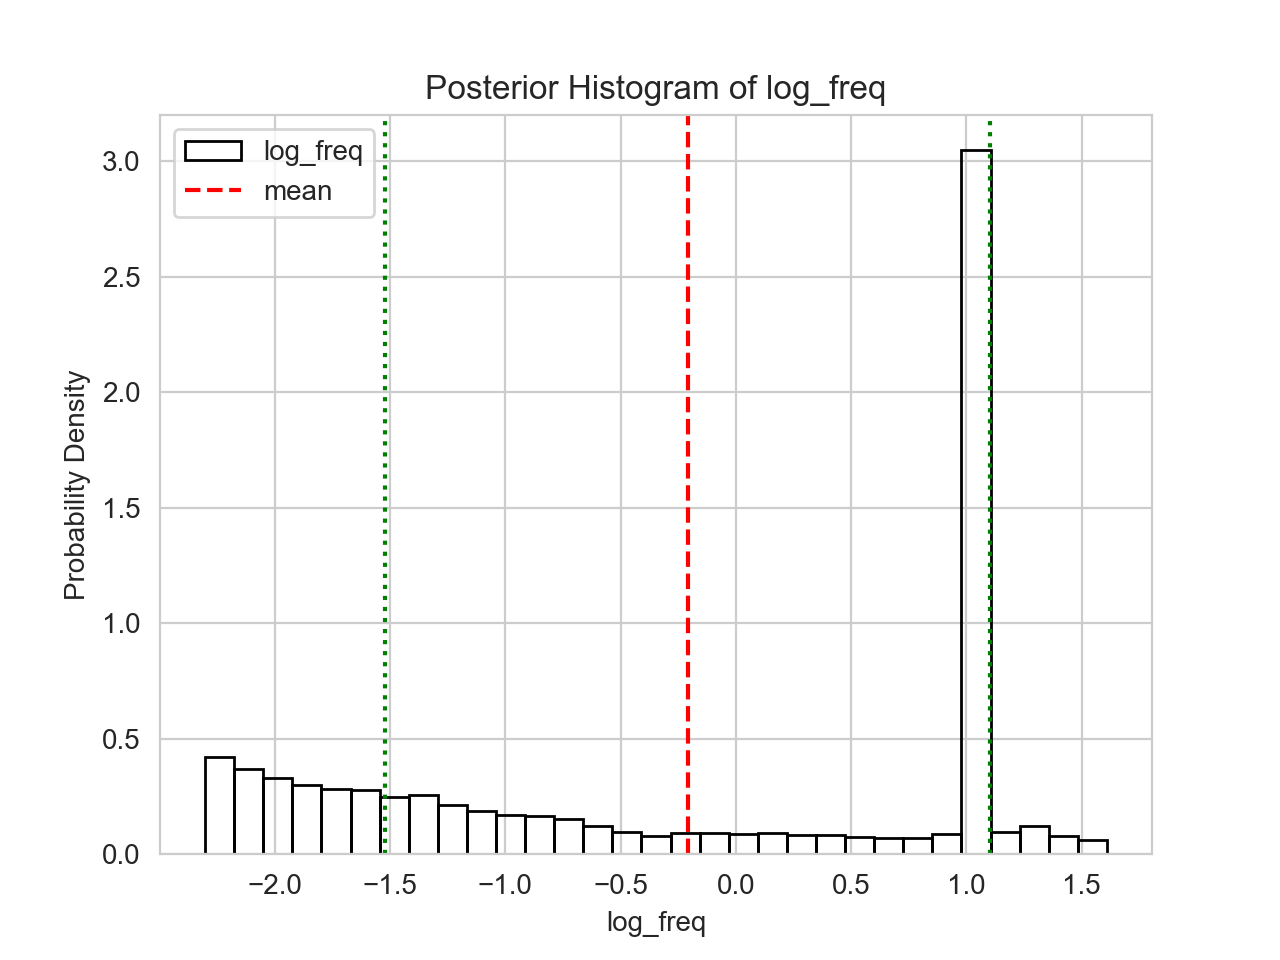

<module 'matplotlib.pyplot' from '/opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [104]:
plt.figure()
gpresult_qporn_cutout.posterior_plot("log_freq")

In [105]:
samples = gpresult_qporn_cutout.results.samples["log_freq"]
rkey = random.PRNGKey(1234)

log_p = gpresult_qporn_cutout.results.log_dp_mean #log-prob
nsamples = gpresult_qporn_cutout.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

In [106]:
freq = np.exp(freq_resampled)
period = 1.0/freq

In [107]:
period

array([0.34660817, 0.34666083, 0.34598762, ..., 0.34724618, 0.3464045 ,
       0.34777959])

<IPython.core.display.Javascript object>


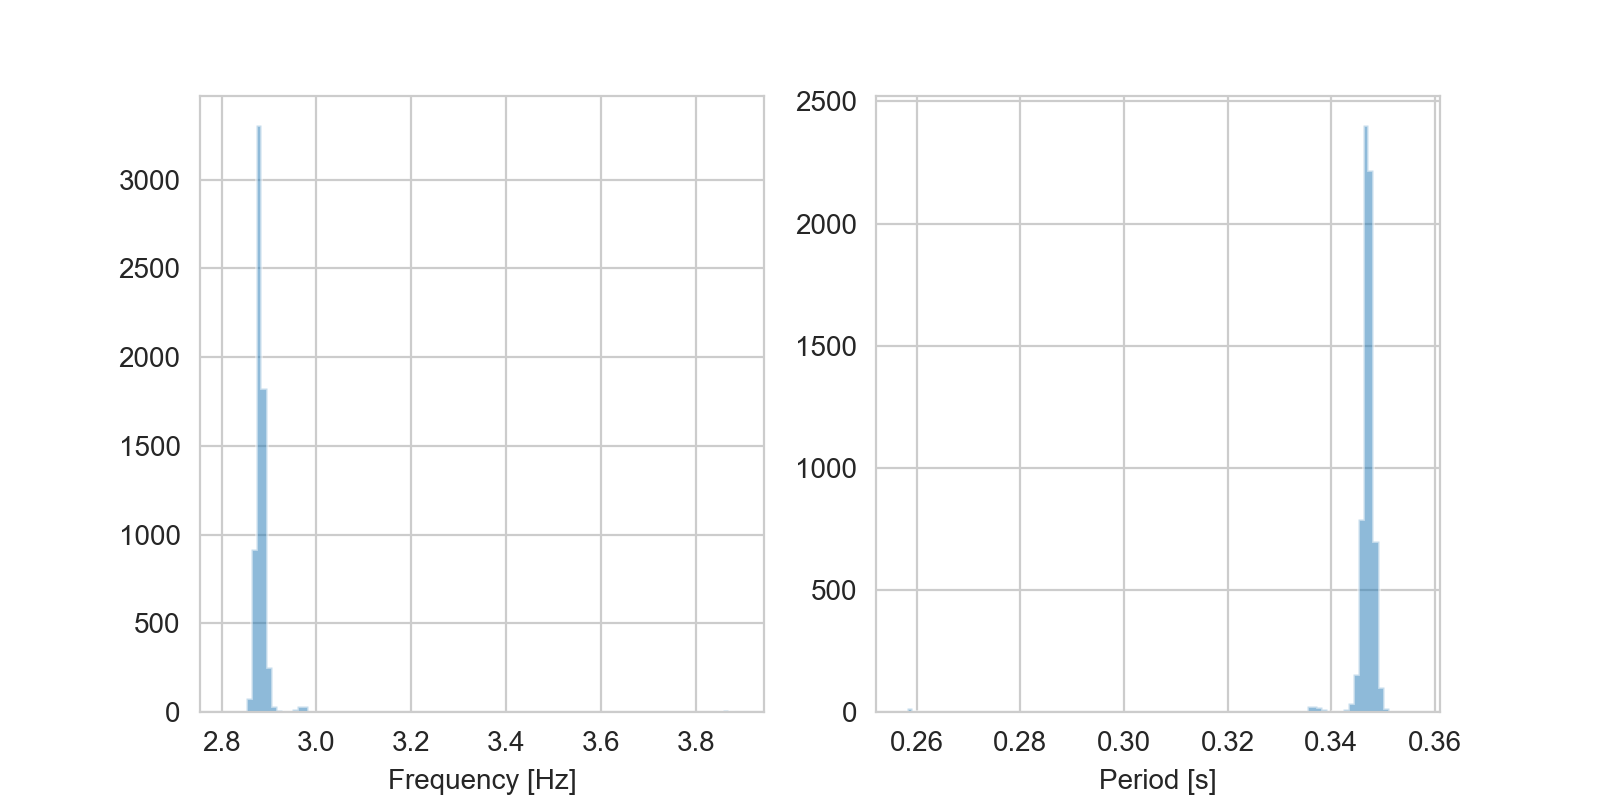

Text(0.5, 0, 'Period [s]')

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [109]:
np.log10(np.exp(gpresult_qporn_cutout.get_evidence() - gpresult_rn_cutout.get_evidence()))

3.997106704967494